# 모델링

| 구분           | X(설명변수)           | Y(타깃)       |   이유          |
| ------------- | -------------------- | ------------- | --------------  |
| ✅ Baseline (현재 단계) | Phase2 + Phase5              | Phase3 `활성지수_100` | 인과성 검증, 중복 배제    |
| 🔁 확장 모델 (다음 단계)   | Phase2 + Phase3(일부) + Phase5 | Phase3 `활성지수_100` | 지수 간 상관·보강 예측 실험 |
| 🧩 심화 모델 (최종 단계)   | 모든 Phase + 외생변수              | 복수 타깃(활성/균형/지속 등) | 총체적 상권반응 모형화     |


※ 모델링 직전 최종 체크

1) 키 타입 강제 통일: 지금은 각 스테이지 내부에서 캐스팅을 해줘서 문제가 없었지만, 모델링 파이프라인 시작 전에 키 타입을 전부 Int64로 통일 필
POP/Stage2/Stage3: 행정동_코드 → String
STORE/SALES/Stage5: 행정동_코드 → Int64

2) 분기 커버리지: STAGE5 기준 group_by("기준_년분기_코드").len()이 전 분기에 대해 417인지 확인.

3) 지표 범위: 변화강도_*와 *_반응지수가 [0,1]에 모두 포함되는지 한 번 더 전수 체크.

4) 로그-차분 일관성: dlog_sales ≈ log_sales - log_sales_L1(Stage5 내부 계산) 샘플 검증 1~2곳만 더 찍어보시면 좋습니다.

## Baseline모델 (Phase2 + Phase5 = 활성지수_100)

### 모델링 실험 (베이스 라인 + 시간누수 방지 세팅)
### t+1분기 예측 via stage 2, 3, 5

In [11]:
# === CONFIG ===
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path

# 입력 파일 경로 
PATH_STAGE2 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage2.parquet"
PATH_STAGE3 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage3.parquet"
PATH_STAGE5 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage5.parquet"

OUT_DIR = Path(r"C:\Users\user\OneDrive\dataset\output\_model")
OUT_DIR.mkdir(parents=True, exist_ok=True)

KEYS = ["행정동_코드", "기준_년분기_코드"]
TARGET_COL = "활성지수_100"  # stage3 기준
SEED = 42

# === 유틸: 분기코드 ⇄ 이동 ===
def next_crym(crym: int, k: int = 1) -> int:
    """예: 20234 -> 20241, 20244 -> 20251 (연/분기 이월 포함)"""
    y, q = divmod(crym, 10)
    if q == 0:  # 방어
        raise ValueError(f"비정상 코드: {crym}")
    q_new = q + k
    y_new = y
    while q_new > 4:
        y_new += 1
        q_new -= 4
    return y_new * 10 + q_new

# === 1) 데이터 로드 ===
s2 = pl.read_parquet(PATH_STAGE2)
s3 = pl.read_parquet(PATH_STAGE3)
s5 = pl.read_parquet(PATH_STAGE5)

# 키/타입 정규화(문자형/정수 혼재 방지)
def norm_keys(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.col(KEYS[0]).cast(pl.Utf8).alias(KEYS[0]),
        pl.col(KEYS[1]).cast(pl.Int32).alias(KEYS[1]),
    ])

s2, s3, s5 = map(norm_keys, (s2, s3, s5))

# === 2) 타깃 t+1 생성 (행정동별로 분기+1의 활성지수_100을 붙임) ===
tgt = (
    s3.select([pl.col(KEYS[0]), pl.col(KEYS[1]), pl.col(TARGET_COL)])
      .with_columns([
          # 기준분기를 t+1로 당겨 '다음 분기 타깃'의 키로 사용
          pl.col(KEYS[1]).map_elements(lambda x: next_crym(int(x), 1), return_dtype=pl.Int32)
                        .alias("기준_년분기_코드_t1")
      ])
      .rename({KEYS[1]: "기준_년분기_코드_orig"})
      .select([
          pl.col(KEYS[0]),
          pl.col("기준_년분기_코드_t1").alias(KEYS[1]),  # 합치기 위해 이름을 원복
          pl.col(TARGET_COL).alias(f"{TARGET_COL}_t1")
      ])
)

# === 3) 피처 결합: stage2 + stage5 (키 유지), stage3는 타깃만 사용 ===
# 공통키 교집합만 사용
panel_x = (
    s2.join(s5, on=KEYS, how="inner", suffix="_s5")
)

# stage3 지표/점수 이름 패턴(혹시 섞여 들어간 경우를 방지하기 위한 필터)
leak_patterns = ["지수", "점수", "_100"]
candidate_feature_cols = [c for c in panel_x.columns if c not in KEYS]
safe_feature_cols = []
for c in candidate_feature_cols:
    # stage5 컬럼은 전부 안전(설계상 지수화지만 외부반응성 전용 특성)
    # 다만 이름에 '지수_100' 등 스코어링 표현이 있어도 stage5는 사용하기로 합의했음
    # stage2 컬럼은 모두 파생이지만 '지수/점수' 네이밍이 드뭅니다.
    # 혹시 stage3가 섞여 들어갔다면 아래 패턴으로 걸러짐.
    if any(pat in c for pat in []) :  # 현재는 비활성(명시적으로 제외할 컬럼 없음을 반영)
        continue
    safe_feature_cols.append(c)

# 최종 피처 DF
X_df = panel_x.select(KEYS + safe_feature_cols)

# === 4) 타깃 병합 ===
panel = X_df.join(tgt, on=KEYS, how="inner")

# 결측/무한치 방어
num_cols = [c for c in panel.columns if c not in KEYS and panel.schema[c].is_numeric()]
panel = panel.with_columns([pl.when(pl.col(c).is_finite()).then(pl.col(c)).otherwise(None).alias(c) for c in num_cols])
panel = panel.drop_nulls(subset=[f"{TARGET_COL}_t1"])  # 타깃 결측 제거
# 너무 엄격한 결측 제거를 피하기 위해 X 결측은 간단 대치(중앙값)로 처리(학습 시점)
# => 모델 파이프라인 내에서 SimpleImputer로 처리할 예정

# pandas로 변환(모델링)
pdf = panel.to_pandas()

# === 5) 시계열 스플릿 정의 ===
def infer_splits(crym_values: pd.Series):
    """마지막 분기 = 테스트, 그 직전 1~3개를 검증, 나머지 학습(데이터 폭에 따라 자동)."""
    uniq = sorted(crym_values.unique())
    if len(uniq) < 5:
        # 데이터가 적으면: 마지막=테스트, 직전=검증, 나머지=학습
        test = [uniq[-1]]
        valid = [uniq[-2]] if len(uniq) >= 2 else []
        train = [u for u in uniq if u not in test + valid]
    else:
        test = [uniq[-1]]
        valid = uniq[-4:-1]  # 최근 3개 분기 검증
        train = [u for u in uniq if u not in test + valid]
    return train, valid, test

train_q, valid_q, test_q = infer_splits(pdf["기준_년분기_코드"])
print("[SPLIT] train:", train_q[:5], "...", " | valid:", valid_q, " | test:", test_q)

def mask_for(crym_list): 
    return pdf["기준_년분기_코드"].isin(crym_list)

df_train = pdf[mask_for(train_q)]
df_valid = pdf[mask_for(valid_q)]
df_test  = pdf[mask_for(test_q)]

# === 6) X/Y 분리 ===
feature_cols = [c for c in safe_feature_cols if c not in KEYS]
X_train, y_train = df_train[feature_cols], df_train[f"{TARGET_COL}_t1"]
X_valid, y_valid = df_valid[feature_cols], df_valid[f"{TARGET_COL}_t1"]
X_test,  y_test  = df_test[feature_cols],  df_test[f"{TARGET_COL}_t1"]

# === 7) 모델 2종 베이스라인 ===
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

# 공통 전처리(결측 대치)
num_transform = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
])

preproc_tree = ColumnTransformer(
    transformers=[("num", num_transform, feature_cols)],
    remainder="drop"
)

preproc_linear = ColumnTransformer(
    transformers=[("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                                    ("sc", StandardScaler())]), feature_cols)],
    remainder="drop"
)

# 1) ElasticNet
pipe_en = Pipeline(steps=[
    ("prep", preproc_linear),
    ("model", ElasticNet(alpha=0.5, l1_ratio=0.2, random_state=SEED, max_iter=10000))
])

# 2) HistGradientBoosting (빠르고 강건)
pipe_hgb = Pipeline(steps=[
    ("prep", preproc_tree),
    ("model", HistGradientBoostingRegressor(
        learning_rate=0.06, max_depth=None, max_iter=600, l2_regularization=0.0,
        random_state=SEED
    ))
])

def eval_and_report(name, pipe, X_tr, y_tr, X_va, y_va, X_te, y_te):
    pipe.fit(X_tr, y_tr)
    preds = {
        "train": pipe.predict(X_tr),
        "valid": pipe.predict(X_va),
        "test":  pipe.predict(X_te),
    }
    def metric(y, p):
        rmse = mean_squared_error(y, p, squared=False)
        mae  = mean_absolute_error(y, p)
        r2   = r2_score(y, p)
        rho, _ = spearmanr(y, p)
        return rmse, mae, r2, rho
    m_tr = metric(y_tr, preds["train"])
    m_va = metric(y_va, preds["valid"])
    m_te = metric(y_te, preds["test"])
    print(f"\n[{name}]")
    print(f"  Train: RMSE={m_tr[0]:.3f}  MAE={m_tr[1]:.3f}  R²={m_tr[2]:.3f}  Spearman={m_tr[3]:.3f}")
    print(f"  Valid: RMSE={m_va[0]:.3f}  MAE={m_va[1]:.3f}  R²={m_va[2]:.3f}  Spearman={m_va[3]:.3f}")
    print(f"  Test : RMSE={m_te[0]:.3f}  MAE={m_te[1]:.3f}  R²={m_te[2]:.3f}  Spearman={m_te[3]:.3f}")
    return pipe, preds

m1, p1 = eval_and_report("ElasticNet", pipe_en, X_train, y_train, X_valid, y_valid, X_test, y_test)
m2, p2 = eval_and_report("HistGB",     pipe_hgb, X_train, y_train, X_valid, y_valid, X_test, y_test)

# === 8) 특성 중요도(퍼뮤테이션; 트리 모델 기준) ===
from sklearn.inspection import permutation_importance
perm = permutation_importance(m2, X_valid, y_valid, n_repeats=10, random_state=SEED, scoring="neg_root_mean_squared_error")
imp_df = (pd.DataFrame({"feature": feature_cols, "importance": perm.importances_mean})
            .sort_values("importance", ascending=False))
print("\n[Permutation importance @Valid — Top 20]")
print(imp_df.head(20))

# === 9) 예측결과 저장 ===
def attach_keys_and_save(split_name, X, y, pred, path):
    out = pd.concat([
        df_valid[KEYS] if split_name=="valid" else (df_test[KEYS] if split_name=="test" else df_train[KEYS]),
        pd.Series(y).rename("y_true"),
        pd.Series(pred).rename("y_pred")
    ], axis=1)
    out.to_parquet(path, index=False)

attach_keys_and_save("valid", X_valid, y_valid, p2["valid"], OUT_DIR / "pred_valid_histgb.parquet")
attach_keys_and_save("test",  X_test,  y_test,  p2["test"],  OUT_DIR / "pred_test_histgb.parquet")

# 전체 결과 요약 CSV
summary = pd.DataFrame([
    {"model":"ElasticNet","split":"valid","rmse":mean_squared_error(y_valid,p1["valid"],squared=False),
     "mae":mean_absolute_error(y_valid,p1["valid"]),"r2":r2_score(y_valid,p1["valid"]),
     "spearman":spearmanr(y_valid,p1["valid"]).correlation},
    {"model":"HistGB","split":"valid","rmse":mean_squared_error(y_valid,p2["valid"],squared=False),
     "mae":mean_absolute_error(y_valid,p2["valid"]),"r2":r2_score(y_valid,p2["valid"]),
     "spearman":spearmanr(y_valid,p2["valid"]).correlation},
    {"model":"ElasticNet","split":"test","rmse":mean_squared_error(y_test,p1["test"],squared=False),
     "mae":mean_absolute_error(y_test,p1["test"]),"r2":r2_score(y_test,p1["test"]),
     "spearman":spearmanr(y_test,p1["test"]).correlation},
    {"model":"HistGB","split":"test","rmse":mean_squared_error(y_test,p2["test"],squared=False),
     "mae":mean_absolute_error(y_test,p2["test"]),"r2":r2_score(y_test,p2["test"]),
     "spearman":spearmanr(y_test,p2["test"]).correlation},
])
summary.to_csv(OUT_DIR / "baseline_summary.csv", index=False)
print("\n[Saved]")
print(OUT_DIR)


[SPLIT] train: [20192, 20193, 20194, 20201, 20202] ...  | valid: [20241, 20242, 20243]  | test: [20244]

[ElasticNet]
  Train: RMSE=4.350  MAE=3.391  R²=0.554  Spearman=0.851
  Valid: RMSE=4.217  MAE=3.273  R²=0.557  Spearman=0.843
  Test : RMSE=4.224  MAE=3.231  R²=0.554  Spearman=0.840


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the func


[HistGB]
  Train: RMSE=0.859  MAE=0.661  R²=0.983  Spearman=0.991
  Valid: RMSE=2.475  MAE=1.928  R²=0.847  Spearman=0.925
  Test : RMSE=2.418  MAE=1.848  R²=0.854  Spearman=0.930

[Permutation importance @Valid — Top 20]
       feature  importance
29   점포생산성_log    4.742978
30   수요당매출_log    3.401880
16        총매출액    2.577967
25  매출표준편차_log    0.589295
24      연령대다양도    0.132763
31       상권포화도    0.128564
1       주간생활비율    0.109093
32      다양성시너지    0.085553
12     업종다양도_대    0.061687
5     생활인구표준편차    0.037294
8          폐업수    0.036196
53  변화강도_sales    0.035279
48    dlog_pop    0.035207
6         총점포수    0.035102
45  유입탄력성_norm    0.034792
26       매출증감률    0.034689
10     프랜차이즈비율    0.033617
46  공급탄력성_norm    0.019576
50  dlog_sales    0.019021
7          개업수    0.017148

[Saved]
C:\Users\user\OneDrive\dataset\output\_model


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the func

### 다중호라이즌 (t+2, t+4) & 모델 확장
### t+1은 baseline-pair로 사용모델이 ElasticNet & HistGradientBoosting이고 최적모델은 아님

In [12]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


In [13]:
# ===========================================================
# ⚙️ 다중 호라이즌 예측 + 모델 확장 (ElasticNet / HistGB / LightGBM / RF)
# ===========================================================
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.inspection import permutation_importance
import lightgbm as lgb

# --------------------------
# 1. CONFIG
# --------------------------
PATH_STAGE2 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage2.parquet"
PATH_STAGE3 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage3.parquet"
PATH_STAGE5 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage5.parquet"

OUT_DIR = Path(r"C:\Users\user\OneDrive\dataset\output\_model_multi")
OUT_DIR.mkdir(parents=True, exist_ok=True)

KEYS = ["행정동_코드", "기준_년분기_코드"]
TARGET_COL = "활성지수_100"
SEED = 42

# --------------------------
# 2. Helper
# --------------------------
def next_crym(crym: int, k: int = 1) -> int:
    y, q = divmod(crym, 10)
    q_new = q + k
    while q_new > 4:
        y += 1
        q_new -= 4
    return y * 10 + q_new

def norm_keys(df):
    return df.with_columns([
        pl.col(KEYS[0]).cast(pl.Utf8),
        pl.col(KEYS[1]).cast(pl.Int32)
    ])

# --------------------------
# 3. Load & merge
# --------------------------
s2 = norm_keys(pl.read_parquet(PATH_STAGE2))
s3 = norm_keys(pl.read_parquet(PATH_STAGE3))
s5 = norm_keys(pl.read_parquet(PATH_STAGE5))

panel_x = s2.join(s5, on=KEYS, how="inner")
feature_cols = [c for c in panel_x.columns if c not in KEYS]

# --------------------------
# 4. Split rule
# --------------------------
def infer_splits(df):
    uniq = sorted(df["기준_년분기_코드"].unique())
    test = [uniq[-1]]
    valid = uniq[-4:-1]
    train = [u for u in uniq if u not in test + valid]
    return train, valid, test

# --------------------------
# 5. Model registry
# --------------------------
def build_models():
    num_pipe = Pipeline([("imp", SimpleImputer(strategy="median"))])
    preproc_lin = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), feature_cols)])
    preproc_tree = ColumnTransformer([("num", num_pipe, feature_cols)])

    return {
        "ElasticNet": Pipeline([("prep", preproc_lin), ("model", ElasticNet(alpha=0.5, l1_ratio=0.2, max_iter=10000, random_state=SEED))]),
        "HistGB": Pipeline([("prep", preproc_tree), ("model", HistGradientBoostingRegressor(random_state=SEED, learning_rate=0.06, max_iter=600))]),
        "LightGBM": lgb.LGBMRegressor(
            n_estimators=800, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
            max_depth=-1, num_leaves=31, random_state=SEED
        ),
        "RandomForest": Pipeline([("prep", preproc_tree), ("model", RandomForestRegressor(
            n_estimators=300, max_depth=None, min_samples_leaf=5, random_state=SEED, n_jobs=-1
        ))])
    }

# --------------------------
# 6. Horizon loop
# --------------------------
records = []
for horizon in [1, 2, 4]:
    print(f"\n=== HORIZON t+{horizon} ===")

    tgt = (
        s3.select(KEYS + [TARGET_COL])
          .with_columns(pl.col("기준_년분기_코드").map_elements(lambda x: next_crym(int(x), horizon), return_dtype=pl.Int32))
          .rename({TARGET_COL: f"{TARGET_COL}_t{horizon}"})
    )

    panel = panel_x.join(tgt, on=KEYS, how="inner").drop_nulls(subset=[f"{TARGET_COL}_t{horizon}"])
    pdf = panel.to_pandas()

    train_q, valid_q, test_q = infer_splits(pdf)
    df_train = pdf[pdf["기준_년분기_코드"].isin(train_q)]
    df_valid = pdf[pdf["기준_년분기_코드"].isin(valid_q)]
    df_test  = pdf[pdf["기준_년분기_코드"].isin(test_q)]

    X_train, y_train = df_train[feature_cols], df_train[f"{TARGET_COL}_t{horizon}"]
    X_valid, y_valid = df_valid[feature_cols], df_valid[f"{TARGET_COL}_t{horizon}"]
    X_test,  y_test  = df_test[feature_cols],  df_test[f"{TARGET_COL}_t{horizon}"]

    models = build_models()

    for name, model in models.items():
        print(f"\n[{name} @t+{horizon}]")
        model.fit(X_train, y_train)
        preds = {
            "train": model.predict(X_train),
            "valid": model.predict(X_valid),
            "test":  model.predict(X_test)
        }

        def metric(y, p):
            rmse = mean_squared_error(y, p, squared=False)
            mae  = mean_absolute_error(y, p)
            r2   = r2_score(y, p)
            rho, _ = spearmanr(y, p)
            return rmse, mae, r2, rho

        for split, (X_, y_, p_) in zip(["train", "valid", "test"], [(X_train, y_train, preds["train"]), (X_valid, y_valid, preds["valid"]), (X_test, y_test, preds["test"])]):
            rmse, mae, r2, rho = metric(y_, p_)
            print(f" {split.capitalize()}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}, Spearman={rho:.3f}")
            records.append({"horizon": horizon, "model": name, "split": split, "rmse": rmse, "mae": mae, "r2": r2, "spearman": rho})

    # --- Permutation Importance (HistGB 기준)
    from sklearn.inspection import permutation_importance
    if "HistGB" in models:
        pipe = models["HistGB"]
        pipe.fit(X_train, y_train)
        perm = permutation_importance(pipe, X_valid, y_valid, n_repeats=10, random_state=SEED, scoring="neg_root_mean_squared_error")
        imp_df = (pd.DataFrame({"feature": feature_cols, "importance": perm.importances_mean})
                    .sort_values("importance", ascending=False)
                    .head(20))
        imp_df.to_csv(OUT_DIR / f"importance_t{horizon}.csv", index=False)
        print(f"Top Features @t+{horizon} saved.")

# --------------------------
# 7. Save summary
# --------------------------
summary = pd.DataFrame(records)
summary.to_csv(OUT_DIR / "baseline_summary_multi.csv", index=False)
print("\n✅ All horizons completed.")
print(f"Results saved → {OUT_DIR}")



=== HORIZON t+1 ===

[ElasticNet @t+1]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Train: RMSE=4.350, MAE=3.391, R²=0.554, Spearman=0.851
 Valid: RMSE=4.217, MAE=3.273, R²=0.557, Spearman=0.843
 Test: RMSE=4.224, MAE=3.231, R²=0.554, Spearman=0.840

[HistGB @t+1]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Train: RMSE=0.859, MAE=0.661, R²=0.983, Spearman=0.991
 Valid: RMSE=2.475, MAE=1.928, R²=0.847, Spearman=0.925
 Test: RMSE=2.418, MAE=1.848, R²=0.854, Spearman=0.930

[LightGBM @t+1]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15721
[LightGBM] [Info] Number of data points in the train set: 7923, number of used features: 62
[LightGBM] [Info] Start training from score 49.999997


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Train: RMSE=0.797, MAE=0.606, R²=0.985, Spearman=0.993
 Valid: RMSE=2.480, MAE=1.943, R²=0.847, Spearman=0.925
 Test: RMSE=2.423, MAE=1.845, R²=0.853, Spearman=0.930

[RandomForest @t+1]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Train: RMSE=1.382, MAE=1.032, R²=0.955, Spearman=0.979
 Valid: RMSE=2.617, MAE=2.021, R²=0.829, Spearman=0.917
 Test: RMSE=2.608, MAE=1.983, R²=0.830, Spearman=0.922
Top Features @t+1 saved.

=== HORIZON t+2 ===

[ElasticNet @t+2]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Train: RMSE=4.400, MAE=3.433, R²=0.543, Spearman=0.841
 Valid: RMSE=4.329, MAE=3.365, R²=0.550, Spearman=0.840
 Test: RMSE=4.156, MAE=3.216, R²=0.545, Spearman=0.825

[HistGB @t+2]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Train: RMSE=0.875, MAE=0.660, R²=0.982, Spearman=0.991
 Valid: RMSE=2.585, MAE=2.024, R²=0.840, Spearman=0.917
 Test: RMSE=2.696, MAE=2.148, R²=0.809, Spearman=0.907

[LightGBM @t+2]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15717
[LightGBM] [Info] Number of data points in the train set: 7506, number of used features: 62
[LightGBM] [Info] Start training from score 49.999998


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Train: RMSE=0.803, MAE=0.605, R²=0.985, Spearman=0.993
 Valid: RMSE=2.577, MAE=2.022, R²=0.841, Spearman=0.918
 Test: RMSE=2.669, MAE=2.158, R²=0.812, Spearman=0.908

[RandomForest @t+2]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Train: RMSE=1.432, MAE=1.065, R²=0.952, Spearman=0.978
 Valid: RMSE=2.686, MAE=2.034, R²=0.827, Spearman=0.913
 Test: RMSE=2.736, MAE=2.127, R²=0.803, Spearman=0.906
Top Features @t+2 saved.

=== HORIZON t+4 ===

[ElasticNet @t+4]
 Train: RMSE=4.479, MAE=3.492, R²=0.524, Spearman=0.824
 Valid: RMSE=4.519, MAE=3.498, R²=0.533, Spearman=0.832
 Test: RMSE=4.388, MAE=3.410, R²=0.547, Spearman=0.841

[HistGB @t+4]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the func

 Train: RMSE=0.822, MAE=0.628, R²=0.984, Spearman=0.992
 Valid: RMSE=2.725, MAE=2.101, R²=0.830, Spearman=0.911
 Test: RMSE=2.719, MAE=2.108, R²=0.826, Spearman=0.909

[LightGBM @t+4]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15712
[LightGBM] [Info] Number of data points in the train set: 6672, number of used features: 62
[LightGBM] [Info] Start training from score 49.999999


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Train: RMSE=0.759, MAE=0.577, R²=0.986, Spearman=0.993
 Valid: RMSE=2.698, MAE=2.079, R²=0.833, Spearman=0.912
 Test: RMSE=2.692, MAE=2.117, R²=0.830, Spearman=0.911

[RandomForest @t+4]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Train: RMSE=1.480, MAE=1.100, R²=0.948, Spearman=0.976
 Valid: RMSE=2.856, MAE=2.143, R²=0.813, Spearman=0.905
 Test: RMSE=2.849, MAE=2.163, R²=0.809, Spearman=0.905
Top Features @t+4 saved.

✅ All horizons completed.
Results saved → C:\Users\user\OneDrive\dataset\output\_model_multi


## 확장모델 (Phase2 + Phase3 + Phase5 = 활성지수_100)

In [14]:
# -*- coding: utf-8 -*-
import os, math, json, warnings
import numpy as np
import polars as pl
from pathlib import Path
import pandas as _pd
from pathlib import Path as _Path

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

import lightgbm as lgb
from scipy.stats import spearmanr

warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(7)

# =============================================================================
# 0) PATHS & CONFIG
# =============================================================================
OUT_DIR = Path(r"C:\Users\user\OneDrive\dataset\output\_model_multi_expanded")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 통합 피처 테이블이 없으므로, 단계별 병합 대상 3개를 직접 읽어 결합
P2 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage2.parquet"
P3 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage3.parquet"
P5 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage5.parquet"

KEYS   = ["행정동_코드", "기준_년분기_코드"]
TARGET = "활성지수_100"            # Phase3
HORIZONS = [1, 2, 4]

# 학습/검증/테스트 분할 (타깃 시점 기준_년분기_코드로 분할)
TRAIN_SET = [20192, 20193, 20194, 20201, 20202, 20203, 20204,
             20211, 20212, 20213, 20214, 20221, 20222, 20223, 20224,
             20231, 20232, 20233, 20234]
VALID_TARGET_SET = [20241, 20242, 20243]
TEST_TARGET_SET  = [20244]

# 캐스팅 정책: 코드가 전부 숫자형이면 True, 앞자리 0 보존 등 문자열 원하면 False
CODE_AS_INT = True

# =============================================================================
# 1) GUARDS & UTILITIES (단일 정의)
# =============================================================================
SP_SUFFIX = "_sp"

def assert_no_sp_columns_in(df: pl.DataFrame, where: str):
    sp_cols = [c for c in df.columns if c.endswith(SP_SUFFIX)]
    assert len(sp_cols) == 0, f"[{where}] Unexpected spatial columns found: {sp_cols}"

NUMERIC_DTYPES = {
    pl.Int8, pl.Int16, pl.Int32, pl.Int64,
    pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
    pl.Float32, pl.Float64,
}

def select_clean_features(
    df: pl.DataFrame,
    base_cols: list[str],
    keys: list[str],
    target: str,
    extra_forbidden_suffixes: list[str] = None,
) -> list[str]:
    """
    - 존재 & 수치형만
    - 키, 타깃/타깃파생, *_sp, 추가 금지 접미사 제거
    - 순서 유지하며 중복 제거
    """
    if extra_forbidden_suffixes is None:
        extra_forbidden_suffixes = []

    dtypes = dict(zip(df.columns, df.dtypes))
    candidates = [c for c in base_cols if (c in dtypes and dtypes[c] in NUMERIC_DTYPES)]

    def banned(c: str) -> bool:
        if c in keys: return True
        if c == target: return True
        if c.endswith(SP_SUFFIX): return True
        if c.startswith(target + "_"): return True  # 예: 활성지수_100_tplus2 등
        for suf in extra_forbidden_suffixes:
            if c.endswith(suf): return True
        return False

    cleaned = [c for c in candidates if not banned(c)]
    cleaned = list(dict.fromkeys(cleaned))  # 순서 유지 중복 제거
    return cleaned

def assert_all_finite(df: pl.DataFrame, cols: list[str], where: str):
    bad = []
    for c in cols:
        if c not in df.columns:
            bad.append((c, "missing", "missing", "missing"))
            continue
        s = df.select(pl.col(c)).to_series()
        if s.len() == 0:
            continue
        # NaN / NULL
        try:
            n_nan = int(df.select(pl.col(c).is_nan().sum().alias("n")).to_numpy()[0][0])
        except Exception:
            n_nan = 0
        n_null = int(df.select(pl.col(c).is_null().sum().alias("n")).to_numpy()[0][0])
        # inf
        v = s.to_numpy()
        n_inf = int(np.isinf(v).sum()) if v.dtype.kind in ("f", "i", "u") else 0
        if (n_nan + n_null + n_inf) > 0:
            bad.append((c, n_nan, n_null, n_inf))
    assert len(bad) == 0, f"[{where}] Non-finite values detected: {bad}"

def load_and_cast(path: str) -> pl.DataFrame:
    """
    세 단계 공통 로더: 중복 정의 금지 (본 함수만 사용)
    - CODE_AS_INT=True  → 행정동_코드:Int64, 기준_년분기_코드:Int32
      False             → 둘 다 문자열(Utf8)
    """
    df = pl.read_parquet(path)
    if CODE_AS_INT:
        df = df.with_columns(
            pl.col("행정동_코드").cast(pl.Int64, strict=False),
            pl.col("기준_년분기_코드").cast(pl.Int32, strict=False),
        )
    else:
        df = df.with_columns(
            pl.col("행정동_코드").cast(pl.Utf8, strict=False),
            pl.col("기준_년분기_코드").cast(pl.Utf8, strict=False),
        )
    return df

# =============================================================================
# 2) LOAD & JOIN (세 소스 병합 · 단일 경로)
# =============================================================================
df2 = load_and_cast(P2)
df3 = load_and_cast(P3)
df5 = load_and_cast(P5)

# 입력 오염 가드: 확장단계에서 *_sp 유입 금지
assert_no_sp_columns_in(df2, "P2")
assert_no_sp_columns_in(df3, "P3")
assert_no_sp_columns_in(df5, "P5")

# 캐스팅 실패 여부 간단 점검
for name, d in [("P2", df2), ("P3", df3), ("P5", df5)]:
    bad_code = d.filter(pl.col("행정동_코드").is_null()).height
    bad_crym = d.filter(pl.col("기준_년분기_코드").is_null()).height
    if bad_code or bad_crym:
        print(f"⚠️ {name}: 캐스팅 후 null 발생 → 코드:{bad_code}, 년분기:{bad_crym}")

# 조인 (Phase2 → Phase3 → Phase5)
df = (
    df2.join(df3, on=KEYS, how="inner", suffix="_p3")
       .join(df5, on=KEYS, how="inner", suffix="_p5")
)

# 병합 산출물도 공간 파생 금지
assert_no_sp_columns_in(df, "merged df")

print("✅ merged:", df.shape)

# =============================================================================
# 3) FEATURE LISTS (비공간 전용 피처 선별)
# =============================================================================
all_cols = df.columns
phase2_cols = [c for c in all_cols if c not in KEYS and c in df2.columns]
phase3_cols = [c for c in all_cols if c not in KEYS and c in df3.columns]
phase5_cols = [c for c in all_cols if c not in KEYS and c in df5.columns]

# Phase3에서 타깃 제외
phase3_x = [c for c in phase3_cols if c != TARGET]

# 1차 병합 리스트
X_cols_raw = list(dict.fromkeys([c for c in (phase2_cols + phase3_x + phase5_cols) if c in all_cols]))

# 최종 사용 피처(비수치/키/타깃/공간 접미사 제거)
X_cols = select_clean_features(
    df=df,
    base_cols=X_cols_raw,
    keys=KEYS,
    target=TARGET,
    extra_forbidden_suffixes=[],
)

print(f"🧹 feature selection: raw={len(X_cols_raw)} -> final={len(X_cols)}")
_dropped = [c for c in X_cols_raw if c not in X_cols]
if _dropped:
    print("   dropped(ex):", _dropped[:30], ("..." if len(_dropped) > 30 else ""))

# =============================================================================
# 4) SUPERVISED SET CREATOR (단일 정의)
# =============================================================================
def make_supervised(df: pl.DataFrame, horizon: int) -> pl.DataFrame:
    """
    각 행정동별로 t 시점 X, t+h 시점 TARGET을 매칭
    - 확장 단계이므로 *_sp 생성/참조 없음
    """
    base = df.select(KEYS + X_cols + [TARGET])
    out = (
        base.sort(KEYS)
        .with_columns([
            pl.col(TARGET).shift(-horizon).over("행정동_코드").alias(f"{TARGET}_tplus{horizon}"),
            pl.col("기준_년분기_코드").shift(-horizon).over("행정동_코드").alias(f"기준_년분기_코드_tplus{horizon}")
        ])
        .drop_nulls([f"{TARGET}_tplus{horizon}", f"기준_년분기_코드_tplus{horizon}"])
    )
    return out

# =============================================================================
# 5) METRICS
# =============================================================================
def eval_reg(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    sp   = spearmanr(y_true, y_pred).correlation
    return rmse, mae, r2, sp

def print_block(name, tr, va, te):
    print(f"\n[{name}]")
    print(f"  Train: RMSE={tr[0]:.3f}  MAE={tr[1]:.3f}  R²={tr[2]:.3f}  Spearman={tr[3]:.3f}")
    print(f"  Valid: RMSE={va[0]:.3f}  MAE={va[1]:.3f}  R²={va[2]:.3f}  Spearman={va[3]:.3f}")
    print(f"  Test : RMSE={te[0]:.3f}  MAE={te[1]:.3f}  R²={te[2]:.3f}  Spearman={te[3]:.3f}")

# =============================================================================
# 6) TRAINING LOOP (확장모델: 비공간)
# =============================================================================
results = {}

for h in HORIZONS:
    print(f"\n=== HORIZON t+{h} ===")
    data_h = make_supervised(df, h)
    target_h   = f"{TARGET}_tplus{h}"
    targetcode = f"기준_년분기_코드_tplus{h}"

    # split (타깃 시점 기준)
    tr = data_h.filter(~pl.col(targetcode).is_in(VALID_TARGET_SET + TEST_TARGET_SET))
    va = data_h.filter(pl.col(targetcode).is_in(VALID_TARGET_SET))
    te = data_h.filter(pl.col(targetcode).is_in(TEST_TARGET_SET))

    # finite 가드
    assert_all_finite(tr, X_cols + [target_h], f"train t+{h}")
    assert_all_finite(va, X_cols + [target_h], f"valid t+{h}")
    assert_all_finite(te, X_cols + [target_h], f"test  t+{h}")

    # Pandas 변환
    X_tr, y_tr = tr.select(X_cols).to_pandas(), tr[target_h].to_pandas().values
    X_va, y_va = va.select(X_cols).to_pandas(), va[target_h].to_pandas().values
    X_te, y_te = te.select(X_cols).to_pandas(), te[target_h].to_pandas().values

    # --- 6.1 ElasticNet (표준화 포함)
    num_proc = ColumnTransformer(
        [("scale", StandardScaler(with_mean=True, with_std=True), list(range(len(X_cols))) )],
        remainder="drop"
    )
    enet = Pipeline([
        ("prep", num_proc),
        ("model", ElasticNet(alpha=0.2, l1_ratio=0.1, max_iter=2000, random_state=7))
    ])
    enet.fit(X_tr, y_tr)
    pred_tr = enet.predict(X_tr); pred_va = enet.predict(X_va); pred_te = enet.predict(X_te)
    m_en_tr = eval_reg(y_tr, pred_tr)
    m_en_va = eval_reg(y_va, pred_va)
    m_en_te = eval_reg(y_te, pred_te)
    print_block("ElasticNet", m_en_tr, m_en_va, m_en_te)

    # --- 6.2 HistGradientBoosting
    hgb = HistGradientBoostingRegressor(
        max_depth=None, max_leaf_nodes=31, learning_rate=0.08, min_samples_leaf=20,
        l2_regularization=0.0, early_stopping=True, validation_fraction=0.1,
        random_state=7
    )
    hgb.fit(X_tr, y_tr)
    pred_tr = hgb.predict(X_tr); pred_va = hgb.predict(X_va); pred_te = hgb.predict(X_te)
    m_hg_tr = eval_reg(y_tr, pred_tr)
    m_hg_va = eval_reg(y_va, pred_va)
    m_hg_te = eval_reg(y_te, pred_te)
    print_block("HistGB", m_hg_tr, m_hg_va, m_hg_te)

    # --- 6.3 LightGBM
    lgbm = lgb.LGBMRegressor(
        n_estimators=1500, learning_rate=0.03, max_depth=-1, num_leaves=63,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=0.0,
        random_state=7, n_jobs=-1
    )
    lgbm.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="rmse",
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )
    pred_tr = lgbm.predict(X_tr); pred_va = lgbm.predict(X_va); pred_te = lgbm.predict(X_te)
    m_lg_tr = eval_reg(y_tr, pred_tr)
    m_lg_va = eval_reg(y_va, pred_va)
    m_lg_te = eval_reg(y_te, pred_te)
    print_block("LightGBM", m_lg_tr, m_lg_va, m_lg_te)

    # [251128 추가]test 예측값 저장 블록
    PRED_DIR = _Path(r"C:\Users\user\OneDrive\dataset\output\_model_compare_exp_vs_adv")
    PRED_DIR.mkdir(parents=True, exist_ok=True)

    # te: Polars DF (make_supervised에서 나온 test 세트)
    # target_h: 예) "활성지수_100_tplus2"
    df_pred_exp = te.select(KEYS + [target_h]).to_pandas()

    # 타깃 이름을 통일해서 y_true로
    df_pred_exp = df_pred_exp.rename(columns={target_h: "y_true"})
    df_pred_exp["y_pred_exp"] = pred_te  # Expanded LGBM의 Test 예측

    out_path_exp = PRED_DIR / f"pred_expanded_tplus{h}.parquet"
    df_pred_exp.to_parquet(out_path_exp, index=False)
    print(f"💾 [Expanded] Test 예측 저장 완료 → {out_path_exp}")

    # --- 6.4 RandomForest (레퍼런스)
    rf = RandomForestRegressor(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        max_features="sqrt", n_jobs=-1, random_state=7
    )
    rf.fit(X_tr, y_tr)
    pred_tr = rf.predict(X_tr); pred_va = rf.predict(X_va); pred_te = rf.predict(X_te)
    m_rf_tr = eval_reg(y_tr, pred_tr)
    m_rf_va = eval_reg(y_va, pred_va)
    m_rf_te = eval_reg(y_te, pred_te)
    print_block("RandomForest", m_rf_tr, m_rf_va, m_rf_te)

    # --------------------------
    # Permutation Importance on VALID (LightGBM 기준)
    # --------------------------
    best_name = "LightGBM"
    best_model = lgbm

    pim = permutation_importance(best_model, X_va, y_va, n_repeats=10, random_state=7, n_jobs=-1)
    imp = sorted(zip(X_cols, pim.importances_mean), key=lambda x: x[1], reverse=True)[:30]
    imp_out = pl.DataFrame({"feature":[k for k,_ in imp], "importance":[float(v) for _,v in imp]})

    # save block
    save_dir = OUT_DIR / f"tplus{h}"
    save_dir.mkdir(parents=True, exist_ok=True)

    pl.from_dicts([
        {"metric":"ElasticNet_train", "rmse":m_en_tr[0], "mae":m_en_tr[1], "r2":m_en_tr[2], "spearman":m_en_tr[3]},
        {"metric":"ElasticNet_valid", "rmse":m_en_va[0], "mae":m_en_va[1], "r2":m_en_va[2], "spearman":m_en_va[3]},
        {"metric":"ElasticNet_test" , "rmse":m_en_te[0], "mae":m_en_te[1], "r2":m_en_te[2], "spearman":m_en_te[3]},
        {"metric":"HistGB_train",    "rmse":m_hg_tr[0], "mae":m_hg_tr[1], "r2":m_hg_tr[2], "spearman":m_hg_tr[3]},
        {"metric":"HistGB_valid",    "rmse":m_hg_va[0], "mae":m_hg_va[1], "r2":m_hg_va[2], "spearman":m_hg_va[3]},
        {"metric":"HistGB_test",     "rmse":m_hg_te[0], "mae":m_hg_te[1], "r2":m_hg_te[2], "spearman":m_hg_te[3]},
        {"metric":"LGBM_train",      "rmse":m_lg_tr[0], "mae":m_lg_tr[1], "r2":m_lg_tr[2], "spearman":m_lg_tr[3]},
        {"metric":"LGBM_valid",      "rmse":m_lg_va[0], "mae":m_lg_va[1], "r2":m_lg_va[2], "spearman":m_lg_va[3]},
        {"metric":"LGBM_test",       "rmse":m_lg_te[0], "mae":m_lg_te[1], "r2":m_lg_te[2], "spearman":m_lg_te[3]},
        {"metric":"RF_train",        "rmse":m_rf_tr[0], "mae":m_rf_tr[1], "r2":m_rf_tr[2], "spearman":m_rf_tr[3]},
        {"metric":"RF_valid",        "rmse":m_rf_va[0], "mae":m_rf_va[1], "r2":m_rf_va[2], "spearman":m_rf_va[3]},
        {"metric":"RF_test",         "rmse":m_rf_te[0], "mae":m_rf_te[1], "r2":m_rf_te[2], "spearman":m_rf_te[3]},
    ]).write_csv(save_dir / "metrics.csv")

    imp_out.write_csv(save_dir / "perm_importance_valid_top30.csv")
    with open(save_dir / "model_lgbm.txt", "w", encoding="utf-8") as f:
        f.write(str(lgbm))

    results[f"t+{h}"] = {
        "best": best_name,
        "n_features": len(X_cols),
        "dropped_examples": _dropped[:20],
        "metrics":{
            "train": dict(rmse=m_lg_tr[0], mae=m_lg_tr[1], r2=m_lg_tr[2], spearman=m_lg_tr[3]),
            "valid": dict(rmse=m_lg_va[0], mae=m_lg_va[1], r2=m_lg_va[2], spearman=m_lg_va[3]),
            "test" : dict(rmse=m_lg_te[0], mae=m_lg_te[1], r2=m_lg_te[2], spearman=m_lg_te[3]),
        }
    }

# 요약 저장
with open(OUT_DIR / "_summary.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("\n✅ Expanded models done.")
print(str(OUT_DIR))


✅ merged: (10008, 133)
🧹 feature selection: raw=85 -> final=85

=== HORIZON t+1 ===

[ElasticNet]
  Train: RMSE=2.548  MAE=1.996  R²=0.847  Spearman=0.928
  Valid: RMSE=2.557  MAE=2.005  R²=0.833  Spearman=0.923
  Test : RMSE=2.320  MAE=1.805  R²=0.866  Spearman=0.942

[HistGB]
  Train: RMSE=1.792  MAE=1.377  R²=0.924  Spearman=0.961
  Valid: RMSE=2.411  MAE=1.861  R²=0.852  Spearman=0.929
  Test : RMSE=2.137  MAE=1.638  R²=0.886  Spearman=0.945
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21570
[LightGBM] [Info] Number of data points in the train set: 7923, number of used features: 85
[LightGBM] [Info] Start training from score 49.999997

[LightGBM]
  Train: RMSE=1.533  MAE=1.184  R²=0.945  Spearman=0.973
  Valid: RMSE=2.410  MAE=1.876  R²=0.852  Spearman=0.928
  Test : RMSE=2.146  MAE=1.637  R²=0.885  Spearman=0.943
💾 [Expanded] Test 예측 저장 

In [15]:
print(f"[t+{h}] n_train={tr.height:,}  n_valid={va.height:,}  n_test={te.height:,}")

[t+4] n_train=6,672  n_valid=1,251  n_test=417


## 심화모델 (Phase2 + Phase3 + Phase5 + 외생변수:공간자기상관 + Cannibalization 임계점 분석)

### 공간자기상관 피처 (Phase-S)

#### 공간가중행렬 W 생성 (연접 + kNN 보완)

In [16]:
import geopandas as gpd
gpd.__version__

'1.1.1'

##### 컬럼 점검

In [17]:
import geopandas as gpd

path = r"C:\Users\user\OneDrive\dataset\data\bnd_dong_11_2024_2Q\bnd_dong_11_2024_2Q.shp"
g = gpd.read_file(path)  # 인코딩 지정 불필요(GeoPandas가 처리)
print("CRS:", g.crs)
print("Columns:", list(g.columns))
print(g.head(3))

CRS: EPSG:5179
Columns: ['BASE_DATE', 'ADM_NM', 'ADM_CD', 'geometry']
  BASE_DATE ADM_NM    ADM_CD  \
0  20240630   잠실4동  11240750   
1  20240630   잠실7동  11240780   
2  20240630   잠실2동  11240790   

                                            geometry  
0  POLYGON ((966144.947 1947247.39, 966140.973 19...  
1  POLYGON ((962306.123 1944876.429, 962298.368 1...  
2  POLYGON ((963373.434 1945897.333, 963372.972 1...  


##### SHP파일 읽기 및 좌표 변환
##### 센트로이드(중심점) 계산
##### 공간가중행렬(W) 만들기

In [18]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

# 1) 행정동 경계 로드
shp = r"C:\Users\user\OneDrive\dataset\data\bnd_dong_11_2024_2Q\bnd_dong_11_2024_2Q.shp"
g = gpd.read_file(shp)  # CRS: EPSG:5179 (미터)
g = g.rename(columns={"ADM_CD": "행정동_코드", "ADM_NM": "행정동명"})
g["행정동_코드"] = g["행정동_코드"].astype(str).str.strip()

# 2) (미터) 센트로이드 → 수치좌표
cent_m = g.geometry.centroid  # 5179에서 계산 → 경고 없음
g["X_m"] = cent_m.x
g["Y_m"] = cent_m.y

# 필요 시 위경도도 저장
cent_ll = gpd.GeoSeries(cent_m, crs=5179).to_crs(4326)
g["lon"] = cent_ll.x
g["lat"] = cent_ll.y

# 3) 저장(선택)
g[["행정동_코드", "행정동명", "X_m", "Y_m", "lon", "lat"]].to_csv(
    r"C:\Users\user\OneDrive\dataset\data\seoul_centroid_2024Q2.csv", index=False
)

# 4) k-NN 공간가중행렬 (미터 좌표로 KNN)
coords = g[["X_m", "Y_m"]].to_numpy()
k = 6
W = kneighbors_graph(coords, n_neighbors=k, mode="connectivity").tocsr()

# (선택) 무방향 대칭화
# W = W.maximum(W.T)

# 행표준화
row_sum = np.maximum(W.sum(axis=1).A.ravel(), 1e-12)
W = sparse.diags(1.0/row_sum) @ W

print("✅ W shape:", W.shape, "| nnz:", W.nnz)

# 5) (선택) 재현성을 위해 저장
sparse.save_npz(r"C:\Users\user\OneDrive\dataset\data\W_knn6_5179_rowstd.npz", W)
g[["행정동_코드"]].to_csv(r"C:\Users\user\OneDrive\dataset\data\W_index_order.csv", index=False)


✅ W shape: (426, 426) | nnz: 2556


In [19]:
from scipy.sparse.csgraph import connected_components
cc = connected_components(W.maximum(W.T), directed=False, return_labels=False)
print("연결 컴포넌트 수:", cc)  # 1이면 OK

연결 컴포넌트 수: 1


##### 공간지연 변수 생성 (누수 방지: 분기별 이웃평균)

In [20]:
# -*- coding: utf-8 -*-
import os
import glob
import numpy as np, polars as pl
from scipy import sparse

# -------------------------------------------------------------------
# 0) PATHS
# -------------------------------------------------------------------
PATH_W   = r"C:\Users\user\OneDrive\dataset\data\W_knn6_5179_rowstd.npz"
PATH_IDX = r"C:\Users\user\OneDrive\dataset\data\W_index_order.csv"  # 열: 행정동_코드

# (우선 시도할) 확장 피처 입력 후보
PATH_FEAT_IN = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_expanded.parquet"

# 대체 후보 패턴(버전 태깅 파일 등)
ALT_PATTERNS = [
    r"C:\Users\user\OneDrive\dataset\output\features\features_ext__CRYM=*.parquet",
    r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_expanded_*.parquet",
]

# 없어도 ADV가 결과만 쓰면 됨
PATH_FEAT_OUT = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_spatial.parquet"

# (필요시 즉석 병합용) 단계별 입력
P2 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage2.parquet"
P3 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage3.parquet"
P5 = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_stage5.parquet"

SP_SUFFIX = "_sp"
KEYS = ["행정동_코드","기준_년분기_코드"]

# 공간지연 대상 후보(존재하는 것만 사용)
X_SP_CANDS = [
    "총생활인구수","주간생활비율","야간생활비율","생활인구표준편차",
    "총점포수","개업수","폐업수","프랜차이즈비율","업종다양도_대",
    "총매출액","주중매출비율","주말매출비율","연령대다양도","매출표준편차_log",
    "점포생산성_log","수요당매출_log","상권포화도","다양성시너지",
    "유입탄력성_norm","공급탄력성_norm","변화강도_pop","변화강도_store","변화강도_sales"
]

# -------------------------------------------------------------------
# 유틸: 확장 피처 DF 로드 (없으면 자동 탐색 → 즉석 병합)
# -------------------------------------------------------------------
def _assert_no_sp(df: pl.DataFrame, where: str):
    bad = [c for c in df.columns if c.endswith(SP_SUFFIX)]
    assert not bad, f"[{where}] *_sp 컬럼이 섞여 있습니다: {bad}"

def load_or_build_extended_features() -> pl.DataFrame:
    # 1) 기본 경로 시도
    if os.path.exists(PATH_FEAT_IN):
        df = pl.read_parquet(PATH_FEAT_IN)
        print(f"📦 EXT features loaded: {PATH_FEAT_IN} | shape={df.shape}")
        return df

    # 2) 대체 패턴 탐색 (가장 최근 파일 선택)
    candidates = []
    for pat in ALT_PATTERNS:
        candidates.extend(glob.glob(pat))
    if candidates:
        # 수정시간 내림차순
        candidates.sort(key=os.path.getmtime, reverse=True)
        for p in candidates:
            try:
                df = pl.read_parquet(p)
                print(f"📦 EXT features loaded (alt): {p} | shape={df.shape}")
                return df
            except Exception:
                continue

    # 3) 최후: P2/P3/P5 즉석 병합 (확장 모델에서 하던 병합을 간단 재현)
    if not (os.path.exists(P2) and os.path.exists(P3) and os.path.exists(P5)):
        raise FileNotFoundError(
            "확장 피처 파일이 없고(PATH_FEAT_IN/ALT_PATTERNS), "
            "즉석 병합용 P2/P3/P5도 찾지 못했습니다. 경로를 확인하세요."
        )

    def load_cast(path: str) -> pl.DataFrame:
        # 심화(W 인덱스와 일치시키기 위해 Utf8 사용(권장))
        return pl.read_parquet(path).with_columns(
            pl.col("행정동_코드").cast(pl.Utf8, strict=False),
            pl.col("기준_년분기_코드").cast(pl.Int32, strict=False),
        )

    df2 = load_cast(P2)
    df3 = load_cast(P3)
    df5 = load_cast(P5)

    _assert_no_sp(df2, "P2"); _assert_no_sp(df3, "P3"); _assert_no_sp(df5, "P5")

    dfm = (
        df2.join(df3, on=KEYS, how="inner", suffix="_p3")
           .join(df5, on=KEYS, how="inner", suffix="_p5")
    )
    print(f"🛠 EXT features built on-the-fly from P2/P3/P5 | shape={dfm.shape}")
    return dfm

# -------------------------------------------------------------------
# 1) W & INDEX (대칭화 + 행표준화)
# -------------------------------------------------------------------
W = sparse.load_npz(PATH_W).tocsr()
idx = pl.read_csv(PATH_IDX)["행정동_코드"].cast(pl.Utf8).to_list()
W = W.maximum(W.T).tocsr()
row_sum = np.maximum(W.sum(axis=1).A.ravel(), 1e-12)
W = sparse.diags(1.0/row_sum) @ W
pos_map = {code: i for i, code in enumerate(idx)}  # ADM코드 → 전역인덱스

# -------------------------------------------------------------------
# 2) FEATURES 로드(없으면 자동 대체)
# -------------------------------------------------------------------
df = load_or_build_extended_features().with_columns(pl.col("행정동_코드").cast(pl.Utf8, strict=False))
_assert_no_sp(df, "ADV input")

# 대상 컬럼 확인
cand_in = [c for c in X_SP_CANDS if c in df.columns]
if not cand_in:
    raise RuntimeError("공간지연 대상 컬럼이 전부 없음 (X_SP_CANDS 재확인 필요)")

# -------------------------------------------------------------------
# 3) 분기 블록 준비 (W 전역 순서 기준 정렬)
# -------------------------------------------------------------------
NUM_DTYPES = (pl.Float32, pl.Float64, pl.Int32, pl.Int64, pl.UInt32, pl.UInt64)

def prepare_quarter_block(part: pl.DataFrame):
    codes = part.select("행정동_코드").to_series().to_list()

    # (옵션) 중복 동 축약
    if len(codes) != len(set(codes)):
        num_cols = [c for c, dt in zip(part.columns, part.dtypes)
                    if c not in KEYS and dt in NUM_DTYPES]
        agg_expr = [pl.mean(c).alias(c) for c in num_cols]
        part = (part.groupby("행정동_코드", maintain_order=True)
                     .agg([pl.first("기준_년분기_코드").alias("기준_년분기_코드"), *agg_expr]))

    uniq_codes = [c for c in part.select("행정동_코드").to_series().unique().to_list() if c in pos_map]
    if not uniq_codes:
        return None, None

    uniq_pos = np.array([pos_map[c] for c in uniq_codes], dtype=np.int32)
    order = np.argsort(uniq_pos)
    codes_by_pos = [uniq_codes[i] for i in order]
    pos_sorted = uniq_pos[order]

    ord_df = pl.DataFrame({"행정동_코드": codes_by_pos, "ord": np.arange(len(codes_by_pos), dtype=np.int32)})
    dd_sorted = (part.join(ord_df, on="행정동_코드", how="inner").sort("ord").drop("ord"))
    return dd_sorted, pos_sorted

# -------------------------------------------------------------------
# 4) 분기별 라그 생성
# -------------------------------------------------------------------
outs = []
for part in df.partition_by("기준_년분기_코드", maintain_order=True):
    dd, pos = prepare_quarter_block(part)
    if dd is None:
        continue

    W_sub = W[pos][:, pos].tocsr()
    rs = np.maximum(W_sub.sum(axis=1).A.ravel(), 1e-12)
    W_sub = sparse.diags(1.0/rs) @ W_sub

    num_in = [c for c, dt in zip(dd.columns, dd.dtypes) if c in cand_in and dt in NUM_DTYPES]
    if not num_in:
        continue

    X = dd.select(num_in).to_numpy()
    X_lag = (W_sub @ X).astype(np.float64)

    lag_cols = [c + SP_SUFFIX for c in num_in]
    outs.append(dd.hstack(pl.DataFrame(X_lag, schema=lag_cols)))

# -------------------------------------------------------------------
# 5) 저장
# -------------------------------------------------------------------
if not outs:
    raise RuntimeError("분기 단위 산출물이 비었습니다. 키/코드 매칭 또는 cand_in을 확인하세요.")

df_sp = pl.concat(outs, how="vertical_relaxed")
df_sp.write_parquet(PATH_FEAT_OUT)
print("✅ saved:", PATH_FEAT_OUT, df_sp.shape)


🛠 EXT features built on-the-fly from P2/P3/P5 | shape=(10008, 133)
✅ saved: C:\Users\user\OneDrive\dataset\output\features\features_mingle_spatial.parquet (768, 156)


##### 공간지연 피처 검증

In [21]:
import polars as pl
df = pl.read_parquet(r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_spatial.parquet")
sp_cols = [c for c in df.columns if c.endswith("_sp")]
print("lag columns:", len(sp_cols))
df.select(sp_cols[:5]).head()


lag columns: 23


총생활인구수_sp,주간생활비율_sp,야간생활비율_sp,생활인구표준편차_sp,총점포수_sp
f64,f64,f64,f64,f64
44588.42399,0.719941,0.280059,1613.737906,407.5
24541.535419,0.603867,0.396133,830.818164,152.0
73430.57793,0.664274,0.335726,1159.458502,818.333333
77967.041041,0.655012,0.344988,791.563784,593.0
75266.849279,0.649121,0.350879,1181.567967,1015.5


##### QA 체크

In [22]:
import polars as pl
p = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_spatial.parquet"
df = pl.read_parquet(p)

# 1) 전부 수치이며 0/NaN 치우침 없는지
sp_cols = [c for c in df.columns if c.endswith("_sp")]
print(len(sp_cols), "sp cols | any_nan:", df.select([pl.any_horizontal([pl.col(c).is_null() for c in sp_cols])]).row(0)[0])

# 2) 원본과 상관(샘플)
print(df.select([(pl.corr("총생활인구수","총생활인구수_sp")).alias("corr_pop")]))


23 sp cols | any_nan: False
shape: (1, 1)
┌───────────┐
│ corr_pop  │
│ ---       │
│ f64       │
╞═══════════╡
│ -0.045686 │
└───────────┘


#### 심화모델

In [23]:
# -*- coding: utf-8 -*-
import os, json, math, warnings
from pathlib import Path
import numpy as np
import polars as pl
import pandas as _pd
from pathlib import Path as _Path

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
import lightgbm as lgb

warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(7)

# =============================================================================
# 0) CONFIG
# =============================================================================
SP_PATH  = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_spatial.parquet"
OUT_DIR  = Path(r"C:\Users\user\OneDrive\dataset\output\_model_multi_advanced")
OUT_DIR.mkdir(parents=True, exist_ok=True)

KEYS     = ["행정동_코드","기준_년분기_코드"]
TARGET   = "활성지수_100"
HORIZONS = [1, 2, 4]

TRAIN_SET = [20192, 20193, 20194, 20201, 20202, 20203, 20204,
             20211, 20212, 20213, 20214, 20221, 20222, 20223, 20224,
             20231, 20232, 20233, 20234]
VALID_TARGET_SET = [20241, 20242, 20243]
TEST_TARGET_SET  = [20244]

SP_SUFFIX = "_sp"
NUM_DTYPES = {pl.Int32, pl.Int64, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64}

# =============================================================================
# 1) ADV 전용 함수들 (확장과 이름/동작 분리)
# =============================================================================
def load_spatial_features_adv(sp_path: str) -> pl.DataFrame:
    """심화 입력: 공간지연 포함 피처 테이블 로드 및 키 캐스팅"""
    assert os.path.exists(sp_path), f"[ADV] 입력 파일 없음: {sp_path}"
    df = pl.read_parquet(sp_path).with_columns(
        pl.col("행정동_코드").cast(pl.Utf8, strict=False),
        pl.col("기준_년분기_코드").cast(pl.Int32, strict=False),
    )
    # 필수 키/타깃 확인
    for c in KEYS + [TARGET]:
        assert c in df.columns, f"[ADV] 필수 컬럼 누락: {c}"
    # 최소 1개 이상의 _sp 컬럼 확인 (심화 단계임을 보장)
    assert any(c.endswith(SP_SUFFIX) for c in df.columns), "[ADV] _sp 피처가 없습니다."
    return df

def build_feature_list_adv(df: pl.DataFrame) -> list[str]:
    """비공간(수치형, 키/타깃 제외) + 공간지연(_sp, 수치형) 합쳐서 최종 X 컬럼"""
    ban = set(KEYS + [TARGET])
    nonsp = [c for c, dt in zip(df.columns, df.dtypes)
             if (c not in ban) and (not c.endswith(SP_SUFFIX)) and (dt in NUM_DTYPES)]
    spcols = [c for c, dt in zip(df.columns, df.dtypes)
              if c.endswith(SP_SUFFIX) and (dt in NUM_DTYPES)]
    xcols  = list(dict.fromkeys(nonsp + spcols))
    print(f"[ADV] feature columns → nonsp={len(nonsp)} | sp={len(spcols)} | total={len(xcols)}")
    return xcols

def make_supervised_adv(df: pl.DataFrame, target: str, keys: list[str], horizon: int,
                        valid_targets: list[int], test_targets: list[int]):
    """t 시점 X → t+h 타깃 매칭 및 split"""
    base = df.select(keys + [target] + [c for c in df.columns if c not in keys+[target]])
    out = (
        base.sort(keys)
        .with_columns([
            pl.col(target).shift(-horizon).over("행정동_코드").alias(f"{target}_tplus{horizon}"),
            pl.col("기준_년분기_코드").shift(-horizon).over("행정동_코드").alias(f"기준_년분기_코드_tplus{horizon}")
        ])
        .drop_nulls([f"{target}_tplus{horizon}", f"기준_년분기_코드_tplus{horizon}"])
    )
    tgt_h   = f"{target}_tplus{horizon}"
    tgtcode = f"기준_년분기_코드_tplus{horizon}"
    tr = out.filter(~pl.col(tgtcode).is_in(valid_targets + test_targets))
    va = out.filter(pl.col(tgtcode).is_in(valid_targets))
    te = out.filter(pl.col(tgtcode).is_in(test_targets))
    return tr, va, te, tgt_h

def assert_all_finite_adv(df: pl.DataFrame, cols: list[str], where: str):
    """NaN/NULL/Inf 체크"""
    bad = []
    for c in cols:
        if c not in df.columns:
            bad.append((c, "missing")); continue
        s = df.select(pl.col(c)).to_series()
        if s.len() == 0: 
            continue
        try:
            n_nan  = int(df.select(pl.col(c).is_nan().sum()).item())
        except Exception:
            n_nan = 0
        n_null = int(df.select(pl.col(c).is_null().sum()).item())
        v = s.to_numpy()
        n_inf = int(np.isinf(v).sum()) if v.dtype.kind in ("f","i","u") else 0
        if (n_nan + n_null + n_inf) > 0:
            bad.append((c, n_nan, n_null, n_inf))
    assert not bad, f"[{where}] Non-finite detected: {bad}"

def eval_reg_adv(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    sp   = spearmanr(y_true, y_pred).correlation
    return rmse, mae, r2, sp

def print_block_adv(name, tr, va, te):
    print(f"\n[{name}]")
    print(f"  Train: RMSE={tr[0]:.3f}  MAE={tr[1]:.3f}  R²={tr[2]:.3f}  Spearman={tr[3]:.3f}")
    print(f"  Valid: RMSE={va[0]:.3f}  MAE={va[1]:.3f}  R²={va[2]:.3f}  Spearman={va[3]:.3f}")
    print(f"  Test : RMSE={te[0]:.3f}  MAE={te[1]:.3f}  R²={te[2]:.3f}  Spearman={te[3]:.3f}")

# =============================================================================
# 2) LOAD & FEATURE LIST
# =============================================================================
df = load_spatial_features_adv(SP_PATH)
X_cols = build_feature_list_adv(df)
X_cols_nonsp = [c for c, dt in zip(df.columns, df.dtypes)
                if (c not in KEYS + [TARGET]) and (not c.endswith(SP_SUFFIX)) and (dt in NUM_DTYPES)]
X_cols_sp    = [c for c, dt in zip(df.columns, df.dtypes)
                if c.endswith(SP_SUFFIX) and (dt in NUM_DTYPES)]

print(f"[ABL] nonsp={len(X_cols_nonsp)}, sp_only={len(X_cols_sp)}, total_with_sp={len(list(dict.fromkeys(X_cols_nonsp+X_cols_sp)))}")

ABL_DIR = OUT_DIR / "_ablation"
ABL_DIR.mkdir(parents=True, exist_ok=True)

# =============================================================================
# 3) TRAIN LOOPS
# =============================================================================
results = {}

for h in HORIZONS:
    print(f"\n=== [ADV] HORIZON t+{h} ===")
    tr, va, te, target_h = make_supervised_adv(
        df, TARGET, KEYS, horizon=h,
        valid_targets=VALID_TARGET_SET, test_targets=TEST_TARGET_SET
    )

    # finite 가드
    assert_all_finite_adv(tr, X_cols + [target_h], f"train t+{h}")
    assert_all_finite_adv(va, X_cols + [target_h], f"valid t+{h}")
    assert_all_finite_adv(te, X_cols + [target_h], f"test  t+{h}")

    # pandas 변환
    X_tr, y_tr = tr.select(X_cols).to_pandas(), tr[target_h].to_pandas().values
    X_va, y_va = va.select(X_cols).to_pandas(), va[target_h].to_pandas().values
    X_te, y_te = te.select(X_cols).to_pandas(), te[target_h].to_pandas().values

    # --- ElasticNet
    enet = Pipeline([
        ("prep", ColumnTransformer([("scale", StandardScaler(), list(range(len(X_cols))) )], remainder="drop")),
        ("model", ElasticNet(alpha=0.2, l1_ratio=0.1, max_iter=2000, random_state=7))
    ])
    enet.fit(X_tr, y_tr)
    m_en_tr = eval_reg_adv(y_tr, enet.predict(X_tr))
    m_en_va = eval_reg_adv(y_va, enet.predict(X_va))
    m_en_te = eval_reg_adv(y_te, enet.predict(X_te))
    print_block_adv("ElasticNet", m_en_tr, m_en_va, m_en_te)

    # --- HistGradientBoosting
    hgb = HistGradientBoostingRegressor(
        max_depth=None, max_leaf_nodes=31, learning_rate=0.08, min_samples_leaf=20,
        l2_regularization=0.0, early_stopping=True, validation_fraction=0.1, random_state=7
    )
    hgb.fit(X_tr, y_tr)
    m_hg_tr = eval_reg_adv(y_tr, hgb.predict(X_tr))
    m_hg_va = eval_reg_adv(y_va, hgb.predict(X_va))
    m_hg_te = eval_reg_adv(y_te, hgb.predict(X_te))
    print_block_adv("HistGB", m_hg_tr, m_hg_va, m_hg_te)

    # --- LightGBM
    lgbm = lgb.LGBMRegressor(
        boosting_type="gbdt",
        n_estimators=2000,
        learning_rate=0.025,
        num_leaves=31,               # 분할 세분화 허용
        max_depth=-1,                # 깊이 제한 없음(데이터가 작아도 과분할 방지 장치 아래 있음)
        min_child_samples=10,        # = min_data_in_leaf
        min_child_weight=1e-2,       # = min_sum_hessian_in_leaf
        feature_fraction=0.85,       # = colsample_bytree
        subsample=0.80,              # = bagging_fraction
        subsample_freq=1,            # = bagging_freq
        reg_alpha=0.1,               # = lambda_l1
        reg_lambda=1.0,              # = lambda_l2
        min_split_gain=0.0,          # = min_gain_to_split
        max_bin=127,
        random_state=7, n_jobs=-1
    )
    
    # 조용한 로그 콜백(평가 로그 숨기기 + 조기종료)
    callbacks = [
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=0)            # <-- 로그 숨김
    ]
    
    lgbm.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="rmse",
        callbacks=callbacks
    )
    y_pred_tr = lgbm.predict(X_tr)
    y_pred_va = lgbm.predict(X_va)
    y_pred_te = lgbm.predict(X_te)
    
    m_lg_tr = eval_reg_adv(y_tr, lgbm.predict(X_tr))
    m_lg_va = eval_reg_adv(y_va, lgbm.predict(X_va))
    m_lg_te = eval_reg_adv(y_te, lgbm.predict(X_te))
    print_block_adv("LightGBM", m_lg_tr, m_lg_va, m_lg_te)

    # [251128 추가] test 예측값 저장 블록
    PRED_DIR = _Path(r"C:\Users\user\OneDrive\dataset\output\_model_compare_exp_vs_adv")
    PRED_DIR.mkdir(parents=True, exist_ok=True)

    df_pred_adv = te.select(KEYS + [target_h]).to_pandas()
    df_pred_adv = df_pred_adv.rename(columns={target_h: "y_true"})
    df_pred_adv["y_pred_adv"] = y_pred_te  # Advanced LGBM의 Test 예측

    out_path_adv = PRED_DIR / f"pred_advanced_tplus{h}.parquet"
    df_pred_adv.to_parquet(out_path_adv, index=False)
    print(f"💾 [Advanced] Test 예측 저장 완료 → {out_path_adv}")

    # --- RandomForest
    rf = RandomForestRegressor(n_estimators=600, max_depth=None, min_samples_leaf=2,
                               max_features="sqrt", n_jobs=-1, random_state=7)
    rf.fit(X_tr, y_tr)
    m_rf_tr = eval_reg_adv(y_tr, rf.predict(X_tr))
    m_rf_va = eval_reg_adv(y_va, rf.predict(X_va))
    m_rf_te = eval_reg_adv(y_te, rf.predict(X_te))
    print_block_adv("RandomForest", m_rf_tr, m_rf_va, m_rf_te)

    # --- Permutation Importance (LGB 기준)
    pim = permutation_importance(lgbm, X_va, y_va, n_repeats=10, random_state=7, n_jobs=-1)
    imp = sorted(zip(X_cols, pim.importances_mean), key=lambda x: x[1], reverse=True)[:30]
    imp_out = pl.DataFrame({"feature":[k for k,_ in imp], "importance":[float(v) for _,v in imp]})

    # save
    save_dir = OUT_DIR / f"tplus{h}"
    save_dir.mkdir(parents=True, exist_ok=True)

    pl.from_dicts([
        {"metric":"ElasticNet_train", "rmse":m_en_tr[0], "mae":m_en_tr[1], "r2":m_en_tr[2], "spearman":m_en_tr[3]},
        {"metric":"ElasticNet_valid", "rmse":m_en_va[0], "mae":m_en_va[1], "r2":m_en_va[2], "spearman":m_en_va[3]},
        {"metric":"ElasticNet_test" , "rmse":m_en_te[0], "mae":m_en_te[1], "r2":m_en_te[2], "spearman":m_en_te[3]},
        {"metric":"HistGB_train",    "rmse":m_hg_tr[0], "mae":m_hg_tr[1], "r2":m_hg_tr[2], "spearman":m_hg_tr[3]},
        {"metric":"HistGB_valid",    "rmse":m_hg_va[0], "mae":m_hg_va[1], "r2":m_hg_va[2], "spearman":m_hg_va[3]},
        {"metric":"HistGB_test",     "rmse":m_hg_te[0], "mae":m_hg_te[1], "r2":m_hg_te[2], "spearman":m_hg_te[3]},
        {"metric":"LGBM_train",      "rmse":m_lg_tr[0], "mae":m_lg_tr[1], "r2":m_lg_tr[2], "spearman":m_lg_tr[3]},
        {"metric":"LGBM_valid",      "rmse":m_lg_va[0], "mae":m_lg_va[1], "r2":m_lg_va[2], "spearman":m_lg_va[3]},
        {"metric":"LGBM_test",       "rmse":m_lg_te[0], "mae":m_lg_te[1], "r2":m_lg_te[2], "spearman":m_lg_te[3]},
        {"metric":"RF_train",        "rmse":m_rf_tr[0], "mae":m_rf_tr[1], "r2":m_rf_tr[2], "spearman":m_rf_tr[3]},
        {"metric":"RF_valid",        "rmse":m_rf_va[0], "mae":m_rf_va[1], "r2":m_rf_va[2], "spearman":m_rf_va[3]},
        {"metric":"RF_test",         "rmse":m_rf_te[0], "mae":m_rf_te[1], "r2":m_rf_te[2], "spearman":m_rf_te[3]},
    ]).write_csv(save_dir / "metrics.csv")

    imp_out.write_csv(save_dir / "perm_importance_valid_top30.csv")
    with open(save_dir / "model_lgbm.txt", "w", encoding="utf-8") as f:
        f.write(str(lgbm))

    results[f"t+{h}"] = {
        "best": "LightGBM",
        "n_features_total": len(X_cols),
        "metrics":{
            "train": dict(rmse=m_lg_tr[0], mae=m_lg_tr[1], r2=m_lg_tr[2], spearman=m_lg_tr[3]),
            "valid": dict(rmse=m_lg_va[0], mae=m_lg_va[1], r2=m_lg_va[2], spearman=m_lg_va[3]),
            "test" : dict(rmse=m_lg_te[0], mae=m_lg_te[1], r2=m_lg_te[2], spearman=m_lg_te[3]),
        }
    }

with open(OUT_DIR / "_summary.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("\n✅ Advanced (spatial-lag) training finished.")
print(str(OUT_DIR))


[ADV] feature columns → nonsp=130 | sp=23 | total=153
[ABL] nonsp=130, sp_only=23, total_with_sp=153

=== [ADV] HORIZON t+1 ===

[ElasticNet]
  Train: RMSE=2.326  MAE=1.829  R²=0.862  Spearman=0.903
  Valid: RMSE=2.494  MAE=1.995  R²=0.840  Spearman=0.898
  Test : RMSE=2.366  MAE=1.895  R²=0.878  Spearman=0.957

[HistGB]
  Train: RMSE=1.373  MAE=0.975  R²=0.952  Spearman=0.970
  Valid: RMSE=2.491  MAE=1.874  R²=0.840  Spearman=0.911
  Test : RMSE=2.105  MAE=1.540  R²=0.903  Spearman=0.947
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18040
[LightGBM] [Info] Number of data points in the train set:

#### expanded vs advanced 유의성검정

In [24]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path

ROOT = Path(r"C:\Users\user\OneDrive\dataset\output")
PRED_DIR = ROOT / "_model_compare_exp_vs_adv"

KEYS = ["행정동_코드", "기준_년분기_코드"]

def ttest_for_horizon(h: int, label: str):
    exp_path = PRED_DIR / f"pred_expanded_tplus{h}.parquet"
    adv_path = PRED_DIR / f"pred_advanced_tplus{h}.parquet"

    df_exp = pd.read_parquet(exp_path)
    df_adv = pd.read_parquet(adv_path)

    # 🔹 1) 키 타입 통일 (행정동_코드 → 문자열, 기준_년분기_코드 → int)
    for c in ["행정동_코드"]:
        df_exp[c] = df_exp[c].astype(str)
        df_adv[c] = df_adv[c].astype(str)

    # 기준_년분기_코드도 혹시 타입 안 맞으면 강제로 int로 맞추기
    for c in ["기준_년분기_코드"]:
        df_exp[c] = df_exp[c].astype(int)
        df_adv[c] = df_adv[c].astype(int)

    # y_true도 숫자로 통일
    df_exp["y_true"] = df_exp["y_true"].astype(float)
    df_adv["y_true"] = df_adv["y_true"].astype(float)

    # 🔹 2) 키 + y_true 기준으로 merge
    df = df_exp.merge(
        df_adv,
        on=KEYS + ["y_true"],
        how="inner",
        suffixes=("_exp", "_adv")
    )

    # 🔹 3) 절대오차 계산 & t-test
    err_exp = np.abs(df["y_true"] - df["y_pred_exp"])
    err_adv = np.abs(df["y_true"] - df["y_pred_adv"])

    mae_exp = err_exp.mean()
    mae_adv = err_adv.mean()

    t_stat, p_two = stats.ttest_rel(err_exp, err_adv, nan_policy="omit")
    p_one = p_two / 2 if t_stat < 0 else 1 - p_two / 2

    return {
        "horizon": label,
        "MAE_exp": mae_exp,
        "MAE_adv": mae_adv,
        "Δ(Adv-Exp)": mae_adv - mae_exp,
        "t_stat": t_stat,
        "p_two_sided": p_two,
        "p_one_sided(Adv<Exp)": p_one,
    }


rows = []
rows.append(ttest_for_horizon(1, "t+1"))
rows.append(ttest_for_horizon(2, "t+2"))
rows.append(ttest_for_horizon(4, "t+4"))

df_ttest = pd.DataFrame(rows)
print(df_ttest)


  horizon   MAE_exp   MAE_adv  Δ(Adv-Exp)    t_stat  p_two_sided  \
0     t+1  1.431929  1.559050    0.127121 -0.822916     0.416841   
1     t+2  1.562887  1.535836   -0.027052  0.126954     0.899797   
2     t+4  1.620196  1.661779    0.041583 -0.262619     0.794582   

   p_one_sided(Adv<Exp)  
0              0.208421  
1              0.550102  
2              0.397291  


## 결과 해석 및 피처 영향 분석

### ① Permutation Importance + 상위 변수 해석

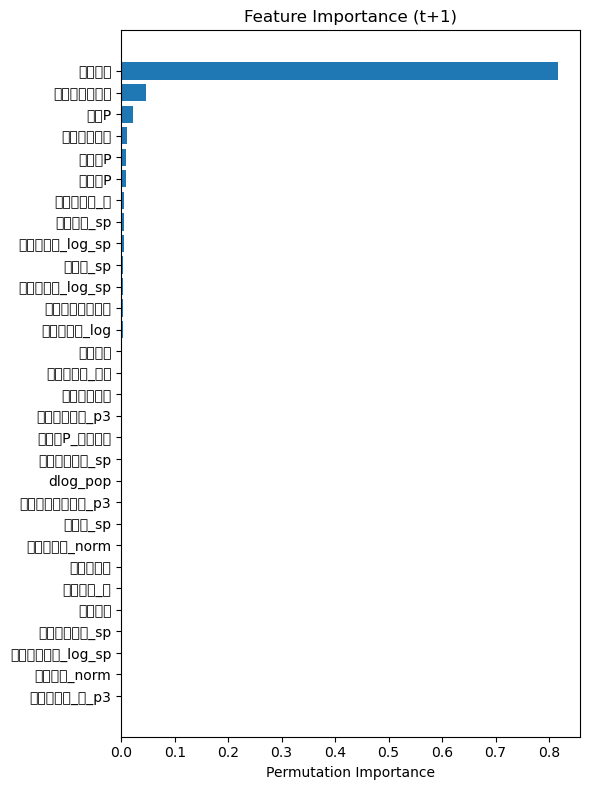

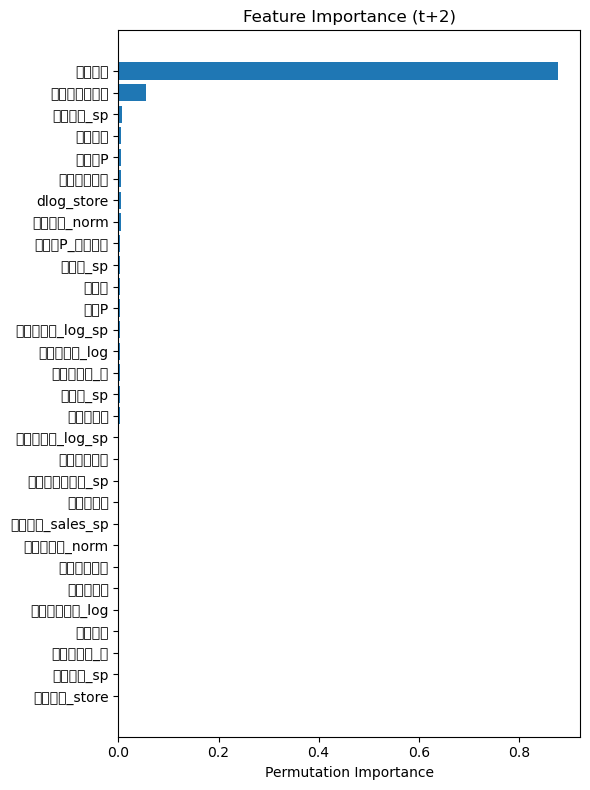

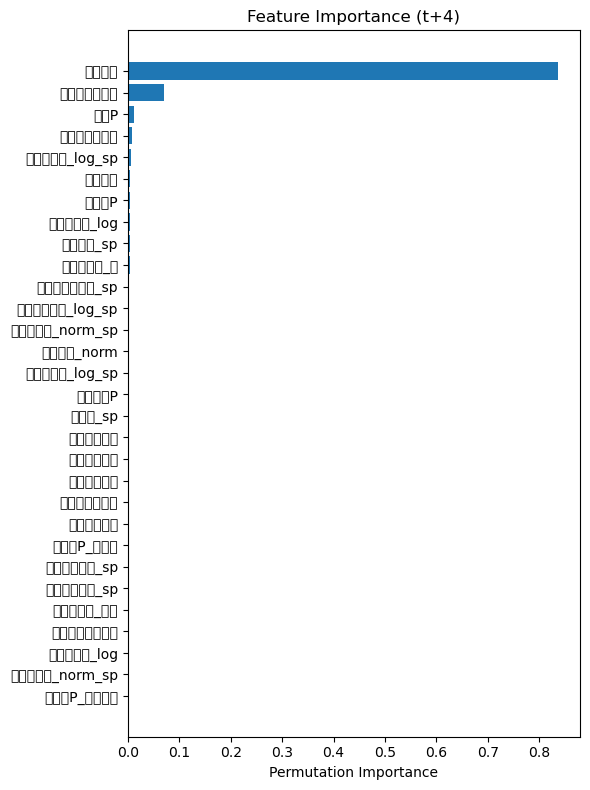

In [25]:
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path

OUT_DIR = Path(r"C:\Users\user\OneDrive\dataset\output\_model_multi_advanced")

for h in [1,2,4]:
    df = pl.read_csv(OUT_DIR / f"tplus{h}" / "perm_importance_valid_top30.csv")
    plt.figure(figsize=(6,8))
    plt.barh(df['feature'][:30][::-1], df['importance'][:30][::-1])
    plt.title(f"Feature Importance (t+{h})")
    plt.xlabel("Permutation Importance")
    plt.tight_layout()
    plt.show()


### ② 확장/심화 모델 성능 비교

In [26]:
import json
import pandas as pd
from pathlib import Path

# -------------------------------------------------------------------
# 0) 경로 설정
# -------------------------------------------------------------------
ROOT = Path(r"C:\Users\user\OneDrive\dataset\output")

MODEL_DIRS = {
    "expanded": ROOT / "_model_multi_expanded",
    "advanced": ROOT / "_model_multi_advanced",
}

# -------------------------------------------------------------------
# 1) summary.json 로드 → long-format DataFrame 생성
# -------------------------------------------------------------------
rows = []

for name, ddir in MODEL_DIRS.items():
    summary_path = ddir / "_summary.json"
    if not summary_path.exists():
        print(f"⚠️ {name}: 요약 파일 없음 -> {summary_path}")
        continue

    with open(summary_path, encoding="utf-8") as f:
        js = json.load(f)

    for horizon, info in js.items():
        m = info["metrics"]
        rows.append({
            "model": name,
            "horizon": horizon,
            "R2_train":      m["train"]["r2"],
            "R2_valid":      m["valid"]["r2"],
            "R2_test":       m["test"]["r2"],
            "RMSE_valid":    m["valid"]["rmse"],
            "RMSE_test":     m["test"]["rmse"],
            "MAE_valid":     m["valid"]["mae"],
            "MAE_test":      m["test"]["mae"],
            "Spearman_valid":m["valid"]["spearman"],
            "Spearman_test": m["test"]["spearman"],
        })

df = pd.DataFrame(rows)

# horizon 정렬 보장 (t+1, t+2, t+4 순서)
order = ["t+1", "t+2", "t+4"]
df["horizon"] = pd.Categorical(df["horizon"], categories=order, ordered=True)
df = df.sort_values(["horizon", "model"])

# -------------------------------------------------------------------
# 2) 핵심 지표별 피벗 테이블
# -------------------------------------------------------------------
def make_pivot(metric_col):
    """metric_col을 기준으로 horizon x model 피벗 생성"""
    p = df.pivot(index="horizon", columns="model", values=metric_col)
    # advanced - expanded Δ열 추가 (두 모델 모두 있을 때만)
    if set(["advanced", "expanded"]).issubset(p.columns):
        p["Δ(adv-exp)"] = p["advanced"] - p["expanded"]
    return p

table_r2_valid   = make_pivot("R2_valid")
table_r2_test    = make_pivot("R2_test")
table_rmse_test  = make_pivot("RMSE_test")
table_mae_test   = make_pivot("MAE_test")
table_sp_test    = make_pivot("Spearman_test")

print("\n[1] Valid R² 비교 (심화 - 확장 Δ 포함)")
print(table_r2_valid.round(4))

print("\n[2] Test R² 비교 (심화 - 확장 Δ 포함)")
print(table_r2_test.round(4))

print("\n[3] Test RMSE 비교 (심화 - 확장 Δ 포함, 값이 낮을수록 좋음)")
print(table_rmse_test.round(4))

print("\n[4] Test MAE 비교 (심화 - 확장 Δ 포함, 값이 낮을수록 좋음)")
print(table_mae_test.round(4))

print("\n[5] Test Spearman 비교 (심화 - 확장 Δ 포함)")
print(table_sp_test.round(4))

# -------------------------------------------------------------------
# 3) (선택) CSV로 저장해두기
# -------------------------------------------------------------------
out_dir = ROOT / "_model_compare_exp_vs_adv"
out_dir.mkdir(parents=True, exist_ok=True)

table_r2_valid.to_csv(out_dir / "valid_R2_compare.csv", encoding="utf-8-sig")
table_r2_test.to_csv(out_dir / "test_R2_compare.csv", encoding="utf-8-sig")
table_rmse_test.to_csv(out_dir / "test_RMSE_compare.csv", encoding="utf-8-sig")
table_mae_test.to_csv(out_dir / "test_MAE_compare.csv", encoding="utf-8-sig")
table_sp_test.to_csv(out_dir / "test_Spearman_compare.csv", encoding="utf-8-sig")

print(f"\n✅ 비교표 CSV 저장 완료 → {out_dir}")



[1] Valid R² 비교 (심화 - 확장 Δ 포함)
model    advanced  expanded  Δ(adv-exp)
horizon                                
t+1        0.8297    0.8521     -0.0224
t+2        0.8609    0.8326      0.0284
t+4        0.8358    0.8227      0.0131

[2] Test R² 비교 (심화 - 확장 Δ 포함)
model    advanced  expanded  Δ(adv-exp)
horizon                                
t+1        0.9048    0.8851      0.0196
t+2        0.8946    0.8525      0.0421
t+4        0.8721    0.8419      0.0302

[3] Test RMSE 비교 (심화 - 확장 Δ 포함, 값이 낮을수록 좋음)
model    advanced  expanded  Δ(adv-exp)
horizon                                
t+1        2.0906    2.1463     -0.0557
t+2        2.1994    2.4324     -0.2330
t+4        2.4233    2.5182     -0.0950

[4] Test MAE 비교 (심화 - 확장 Δ 포함, 값이 낮을수록 좋음)
model    advanced  expanded  Δ(adv-exp)
horizon                                
t+1        1.5590    1.6373     -0.0783
t+2        1.5358    1.9295     -0.3936
t+4        1.6618    1.9523     -0.2905

[5] Test Spearman 비교 (심화 - 확장 Δ 포함)
model    ad

# 공간적 자기상관 및 Cannibalization 분석

## 공통 준비 코드 (W + 피처로드 & 정렬 헬퍼)

In [27]:
import numpy as np
import polars as pl
from scipy import sparse

# ----- PATHS -----
PATH_W   = r"C:\Users\user\OneDrive\dataset\data\W_knn6_5179_rowstd.npz"
PATH_IDX = r"C:\Users\user\OneDrive\dataset\data\W_index_order.csv"
PATH_FEAT_SP = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_spatial.parquet"

KEYS = ["행정동_코드","기준_년분기_코드"]
TARGET = "활성지수_100"

# ----- 0-1. W & index 로드 (대칭화 + 행표준화) -----
W = sparse.load_npz(PATH_W).tocsr()
idx = pl.read_csv(PATH_IDX)["행정동_코드"].cast(pl.Utf8).to_list()

W = W.maximum(W.T).tocsr()
row_sum = np.maximum(W.sum(axis=1).A.ravel(), 1e-12)
W = sparse.diags(1.0/row_sum) @ W

pos_map = {code: i for i, code in enumerate(idx)}

# ----- 0-2. 공간 피처 로드 -----
df_all = pl.read_parquet(PATH_FEAT_SP).with_columns(
    pl.col("행정동_코드").cast(pl.Utf8),
    pl.col("기준_년분기_코드").cast(pl.Int32),
)

# ----- 0-3. 분기별로 W 순서에 맞춰 벡터/행렬 뽑는 헬퍼 -----
def align_quarter_to_W(crym_code: int, value_col: str):
    """
    특정 분기(crym_code)에서 value_col 벡터를
    'W의 전역 인덱스 순서'에 맞춰 np.array로 반환.

    반환:
      y_full: (N_total,)  # 없는 동은 np.nan
      mask:   (N_total,) bool  # 이 분기에 실제로 존재하는 동
    """
    part = df_all.filter(pl.col("기준_년분기_코드") == crym_code)

    # 이 분기에 있는 동들 중, W에 존재하는 동만 사용
    codes = [c for c in part["행정동_코드"].to_list() if c in pos_map]
    if not codes:
        raise ValueError(f"분기 {crym_code} 에 사용 가능한 행정동이 없습니다.")

    # part 값 정렬 (y 채우기용)
    pos = np.array([pos_map[c] for c in codes], dtype=np.int32)
    order = np.argsort(pos)
    codes_sorted = [codes[i] for i in order]
    pos_sorted   = pos[order]

    part_sorted_sub = (part.join(
            pl.DataFrame({"행정동_코드": codes_sorted, "ord": np.arange(len(codes_sorted))}),
            on="행정동_코드",
            how="inner")
        .sort("ord")
        .drop("ord")
    )

    y_sub = part_sorted_sub[value_col].to_numpy()

    # --- 전체 W 기준 embedding ---
    N = W.shape[0]
    y_full = np.full(N, np.nan, dtype=float)
    y_full[pos_sorted] = y_sub

    mask = ~np.isnan(y_full)

    # ✅ 전체 행정동 기준 part_sorted (W 순서)
    codes_all = list(pos_map.keys())
    pos_all = np.array([pos_map[c] for c in codes_all], dtype=np.int32)
    order_all = np.argsort(pos_all)
    codes_all_sorted = [codes_all[i] for i in order_all]

    part_sorted = pl.DataFrame({"행정동_코드": codes_all_sorted})

    return y_full, mask, part_sorted


## 1. Global Moran’s I (공간적 자기상관 전역 지수)

### 1-1. Moran’s I 함수

In [28]:
def morans_I(W, y, mask=None, permutations=999, random_state=7):
    """
    Global Moran's I를 계산하고, perm 테스트로 p-value 추정.

    y: (N,) 벡터, 일부 np.nan 가능
    mask: 유효한 위치(True)만 사용할 때
    """
    rng = np.random.default_rng(random_state)

    if mask is None:
        mask = ~np.isnan(y)

    y = y.astype(float)
    y_valid = y[mask]
    if y_valid.size < 3:
        raise ValueError("유효 관측치가 너무 적습니다.")

    # W 서브셋
    W_sub = W[mask][:, mask].tocsr()

    # 행합 0 방지 행표준화 한번 더
    rs = np.maximum(W_sub.sum(axis=1).A.ravel(), 1e-12)
    W_sub = sparse.diags(1.0/rs) @ W_sub

    x = y_valid
    x_bar = x.mean()
    x_dev = x - x_bar

    num = x_dev @ (W_sub @ x_dev)
    den = (x_dev ** 2).sum()
    N = x.size
    S0 = W_sub.sum()

    I = (N / S0) * (num / den)

    # permutation test
    perm_I = np.empty(permutations)
    for i in range(permutations):
        x_perm = rng.permutation(x)
        num_p  = (x_perm - x_perm.mean()) @ (W_sub @ (x_perm - x_perm.mean()))
        den_p  = ((x_perm - x_perm.mean()) ** 2).sum()
        perm_I[i] = (N / S0) * (num_p / den_p)

    p_sim = (np.sum(np.abs(perm_I) >= np.abs(I)) + 1) / (permutations + 1)
    return I, p_sim, perm_I


## 2. LISA (Local Moran’s I) + Hotspot/Coldspot 분류

### 2-1. Local Moran’s I 계산 함수

In [29]:
def local_morans_I(W, y, mask=None, permutations=999, random_state=7):
    """
    Local Moran's I (Anselin) + perm 기반 p-value.
    반환: dict (keys: 'Ii','z','p','lag','x_std')
    """
    rng = np.random.default_rng(random_state)

    if mask is None:
        mask = ~np.isnan(y)

    y = y.astype(float)
    y_valid = y[mask]
    if y_valid.size < 3:
        raise ValueError("유효 관측치가 너무 적습니다.")

    W_sub = W[mask][:, mask].tocsr()
    rs = np.maximum(W_sub.sum(axis=1).A.ravel(), 1e-12)
    W_sub = sparse.diags(1.0/rs) @ W_sub

    x = y_valid
    x_bar = x.mean()
    x_dev = x - x_bar
    s2 = (x_dev ** 2).sum() / (x.size - 1)
    x_std = x_dev / np.sqrt(s2)

    # spatial lag of deviation (Ii 계산용)
    Wx = W_sub @ x_dev

    Ii = (x_dev * Wx) / s2

    # perm
    perm_I = np.empty((permutations, x.size))
    for p in range(permutations):
        x_perm = rng.permutation(x)
        x_perm_dev = x_perm - x_perm.mean()
        Wx_perm = W_sub @ x_perm_dev
        perm_I[p] = (x_perm_dev * Wx_perm) / s2

    mean_I = perm_I.mean(axis=0)
    std_I  = perm_I.std(axis=0, ddof=1)
    z = (Ii - mean_I) / std_I
    p = (np.sum(np.abs(perm_I) >= np.abs(Ii), axis=0) + 1) / (permutations + 1)

    # spatial lag of standardized values (사분면 분류/지도용)
    lag = W_sub @ x_std
    return {"Ii": Ii, "z": z, "p": p, "lag": lag, "x_std": x_std, "mask": mask}


### 2-2. 클러스터 타입(HH/LL/HL/LH) 라벨링

In [30]:
CRYM_TARGET = 20244

y_full, mask, part_sorted = align_quarter_to_W(CRYM_TARGET, "활성지수_100")  # value_col만 넣기
res = local_morans_I(W, y_full, mask=None, permutations=999)
mask = res["mask"]  # 실제 계산에 사용된 mask(= ~isnan(y_full))


alpha = 0.05
sig = res["p"] < alpha

x_std = res["x_std"]
lag   = res["lag"]
Ii    = res["Ii"]

cluster = np.full_like(Ii, "NotSig", dtype=object)

# quadrant 기준 (Anselin)
# x_std >0, lag>0: HH
# x_std <0, lag<0: LL
# x_std >0, lag<0: HL (High surrounded by Low)
# x_std <0, lag>0: LH (Low surrounded by High)

cluster[(sig) & (x_std > 0) & (lag > 0)] = "HH"
cluster[(sig) & (x_std < 0) & (lag < 0)] = "LL"
cluster[(sig) & (x_std > 0) & (lag < 0)] = "HL"
cluster[(sig) & (x_std < 0) & (lag > 0)] = "LH"

# (추가) 유의성 무관한 전체 quadrant 분류 (패턴 지도용)
cluster_all = np.where((x_std > 0) & (lag > 0), "HH",
               np.where((x_std < 0) & (lag < 0), "LL",
               np.where((x_std > 0) & (lag < 0), "HL", "LH")))

N = len(y_full)

Ii_full = np.full(N, np.nan);   Ii_full[mask] = res["Ii"]
p_full  = np.full(N, np.nan);   p_full[mask]  = res["p"]
z_full  = np.full(N, np.nan);   z_full[mask]  = res["z"]

# 유의 클러스터(32개만 계산된 것 -> 426으로 확장)
cluster_sig_full = np.full(N, "NotSig", dtype=object)
cluster_sig_full[mask] = cluster  # cluster는 32개짜리

# 전체 사분면(32개만 계산된 것 -> 426으로 확장)
cluster_all_full = np.full(N, None, dtype=object)
cluster_all_full[mask] = cluster_all  # cluster_all은 32개짜리


# 결과 DF 조인
out_lisa = part_sorted.with_columns(
    pl.Series("Ii", Ii_full),
    pl.Series("Ii_p", p_full),
    pl.Series("Ii_z", z_full),
    pl.Series("Ii_cluster", cluster_sig_full),
    pl.Series("Ii_cluster_all", cluster_all_full),
)

save_path = r"C:\Users\user\OneDrive\dataset\output\_spatial\lisa_활성지수_20244.csv"
Path(save_path).parent.mkdir(parents=True, exist_ok=True)

# Polars → Pandas 변환
out_lisa_pd = out_lisa.to_pandas()

# pandas로 UTF-8-SIG 저장
out_lisa_pd.to_csv(save_path, encoding="utf-8-sig", index=False)

print("✅ LISA 저장 완료:", save_path, "| shape:", out_lisa.shape)

✅ LISA 저장 완료: C:\Users\user\OneDrive\dataset\output\_spatial\lisa_활성지수_20244.csv | shape: (426, 6)


C:\Users\user\AppData\Local\Temp\ipykernel_26916\4112539132.py:41: RuntimeWarning: invalid value encountered in divide
  z = (Ii - mean_I) / std_I


In [31]:
print("len(y_full):", len(y_full))
print("mask True count:", mask.sum())
print("part_sorted shape:", part_sorted.shape)


len(y_full): 426
mask True count: 32
part_sorted shape: (426, 1)


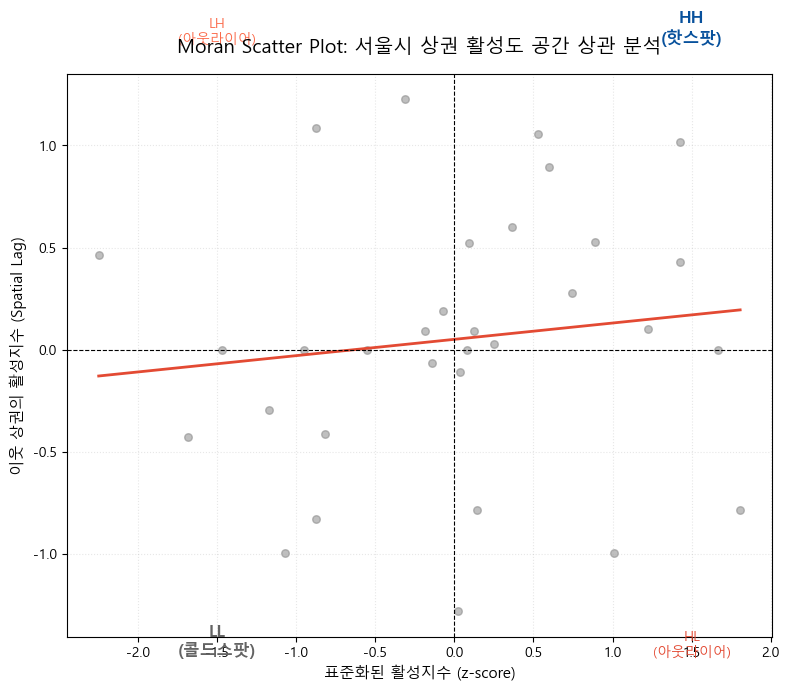

✅ 모란 산점도 저장 완료: C:\Users\user\OneDrive\dataset\output\_spatial\moran_scatter_20244.png


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 2. 산점도 그리기
plt.figure(figsize=(8, 7))

# res에서 계산된 값을 직접 사용합니다.
# x축: 나의 표준화된 활성지수 (x_std)
# y축: 내 주변의 표준화된 활성지수 (lag)
sns.regplot(x=res["x_std"], y=res["lag"], 
            ci=None, 
            scatter_kws={'alpha': 0.5, 's': 30, 'color': 'gray'},
            line_kws={'color': '#e34a33', 'lw': 2})

# 3. 기준선(0,0) 추가
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

# 4. 사분면 설명 텍스트 추가 (인사이트 강조용)
# 오른쪽 위(HH), 왼쪽 아래(LL)가 공간적 자기상관을 증명하는 핵심 구역입니다.
plt.text(1.5, 1.5, "HH\n(핫스팟)", fontsize=12, color='#08519c', fontweight='bold', ha='center')
plt.text(-1.5, -1.5, "LL\n(콜드스팟)", fontsize=12, color='#636363', fontweight='bold', ha='center')
plt.text(1.5, -1.5, "HL\n(아웃라이어)", fontsize=10, color='#e34a33', ha='center')
plt.text(-1.5, 1.5, "LH\n(아웃라이어)", fontsize=10, color='#fb6a4a', ha='center')

# 5. 제목 및 축 레이블
plt.title("Moran Scatter Plot: 서울시 상권 활성도 공간 상관 분석", fontsize=14, pad=15)
plt.xlabel("표준화된 활성지수 (z-score)", fontsize=11)
plt.ylabel("이웃 상권의 활성지수 (Spatial Lag)", fontsize=11)

plt.grid(True, linestyle=':', alpha=0.3)
plt.tight_layout()

# 6. 이미지 저장
out_fig_path = r"C:\Users\user\OneDrive\dataset\output\_spatial\moran_scatter_20244.png"
plt.savefig(out_fig_path, dpi=300)
plt.show()

print(f"✅ 모란 산점도 저장 완료: {out_fig_path}")

## 3. Spatial Lag 회귀 (간단 버전)

### 3-1. 단일 분기에서 WX + X로 회귀

In [32]:
import pandas as pd
import statsmodels.api as sm

CRYM_TARGET = 20244

# 1) y + 설계행렬 X (일단 intercept + 공간지연만 예시)
y_full, mask, part_sorted = align_quarter_to_W(CRYM_TARGET, TARGET)

# 공간지연 Wy (W_sub @ y_sub)
W_sub = W[mask][:, mask].tocsr()
rs = np.maximum(W_sub.sum(axis=1).A.ravel(), 1e-12)
W_sub = sparse.diags(1.0/rs) @ W_sub

y_sub = y_full[mask]
Wy = (W_sub @ y_sub)

X = pd.DataFrame({
    "const": 1.0,
    "y_lag": Wy,
    # 필요하면 다른 설명변수도 여기 넣기 (예: 총생활인구수, 총점포수 등)
})

model = sm.OLS(y_sub, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.5279
Date:                Fri, 30 Jan 2026   Prob (F-statistic):              0.473
Time:                        02:44:34   Log-Likelihood:                -106.35
No. Observations:                  32   AIC:                             216.7
Df Residuals:                      30   BIC:                             219.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5977      3.037     16.661      0.0

## 4. Cannibalization Threshold 분석

### 4-1. Δy, Δy_neigh 계산

In [33]:
H = 1  # horizon

# 1) y_t, y_t1 벡터(모두 W 순서에 맞춤)
CRYM_T   = 20243
CRYM_T1  = 20244

y_t, mask_t, part_t   = align_quarter_to_W(CRYM_T,  TARGET)
y_t1, mask_t1, part_t1 = align_quarter_to_W(CRYM_T1, TARGET)

# 공통으로 존재하는 동만 사용 (mask 교차)
mask_both = mask_t & mask_t1

y_t  = y_t[mask_both]
y_t1 = y_t1[mask_both]

W_sub = W[mask_both][:, mask_both].tocsr()
rs = np.maximum(W_sub.sum(axis=1).A.ravel(), 1e-12)
W_sub = sparse.diags(1.0/rs) @ W_sub

dy = y_t1 - y_t                   # 대상 상권 활성도 변화
dneigh = W_sub @ dy               # 이웃 상권 활성도 변화의 공간지연
yneigh_t = W_sub @ y_t            # 이웃 현재 수준

print("Δy 통계:", dy.mean(), dy.std())
print("Δy_neigh 통계:", dneigh.mean(), dneigh.std())


Δy 통계: 0.30778124999999945 2.207656417651633
Δy_neigh 통계: 0.3636692708333324 1.3722905720993395


✔ 해석:
전체적으로 상권 활성도는 소폭 증가 경향(+)
다만 변동 폭은 상권별 편차가 커서 (std 2.2) 이웃 상권 변화는 상대적으로 더 안정적(std 1.37)
➡ 이웃 변화(공급·수요 변화)가 개별 상권보다 완만하게 변한다는 의미이며 Cannibalization 분석이 성립되는 조건에 부합

### 4-2. Cannibalization 임계점 탐색 (단순 Q-binning)

In [34]:
import pandas as pd
import numpy as np

df_cann = pd.DataFrame({
    "dy": dy,
    "dneigh": dneigh,
    "yneigh_t": yneigh_t,
})

# 이웃 변화량을 분위수 기반 20구간으로 나누기
df_cann["bin_dneigh"] = pd.qcut(df_cann["dneigh"], q=20, duplicates="drop")

group = df_cann.groupby("bin_dneigh", observed=True).agg(
    dy_mean=("dy","mean"),
    dy_std=("dy","std"),
    cnt=("dy","size"),
    dneigh_mean=("dneigh","mean"),
).reset_index()

print(group)

# 임계점 후보: dy_mean이 처음으로 0 아래로 떨어지는 구간
candidates = group[group["dy_mean"] < 0]
if not candidates.empty:
    thr = candidates.iloc[0]["dneigh_mean"]
    print(f"\n⚠️ Cannibalization threshold (candidate): 이웃 Δy ≈ {thr:.3f} 이상에서 대상 Δy 평균 < 0")
else:
    print("\n별도의 감소 구간이 명확히 나타나지 않습니다.")


                       bin_dneigh  dy_mean    dy_std  cnt  dneigh_mean
0   (-3.3249999999999997, -1.719]  -0.3880  0.896611    2    -2.562000
1                (-1.719, -1.194]   0.4690  0.731148    2    -1.433500
2                (-1.194, -0.865]   0.7930       NaN    1    -1.009000
3                (-0.865, -0.181]   1.5260  1.652471    3    -0.382667
4              (-0.0654, -0.0126]  -2.1665  1.636952    2    -0.022500
5                  (-0.0126, 0.0]  -0.8858  1.848256    5     0.000000
6                    (0.0, 0.123]  -3.5520       NaN    1     0.099000
7                   (0.123, 0.23]   1.5025  1.605840    2     0.187583
8                   (0.23, 0.305]   0.3010       NaN    1     0.261500
9                  (0.305, 0.661]  -0.3155  0.666802    2     0.484000
10                 (0.661, 0.935]  -0.8470       NaN    1     0.814500
11                  (0.935, 1.26]   0.3335  0.191626    2     1.115833
12                  (1.26, 1.459]   1.3170       NaN    1     1.304000
13    

이웃 상권이 강하게 쇠퇴하면 → 대상 상권 활성도도 동반 하락하는 동행도(Co-decline) 패턴이 나타남.
🔥 요약:
이웃 증가 → 대상 증가 (보완효과)
이웃 감소 → 대상 감소 (동반침체)
특정 구간에서 경쟁효과(cannibalization) 발생
➡ 상권 간 관계는 단순한 경쟁(cannibalization)만이 아니라 보완 및 동행 구조가 공존한다는 고급 해석이 가능함!